# Introduction

Our project focuses on predicting strokes within humans. The dataset is extensive, containing over 5100 examples and including features such as gender, age, hypertenstion, heart disease, marriage, job occupation, residence type, glucose levels, bmi, and smoking status. These features will be used to make a binary prediction of whether that person has had a stroke or not. This is very interesting as our analysis describes what factors contribute most and least to strokes. This information can be informative regarding medical and health practices.

# Setup

In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import torch

In [409]:
# Initialize DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Initial Analysis

In [410]:
# Dataset Overview
print("Dataset Shape:", df.shape)

print("\nColumn Data Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nMissing BMI: {df['bmi'].isnull().sum()} ({df['bmi'].isnull().sum()/len(df)*100:.2f}%)")

Dataset Shape: (5110, 11)

Column Data Types:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Basic Statistics:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.0

Stroke Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Stroke Percentage:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


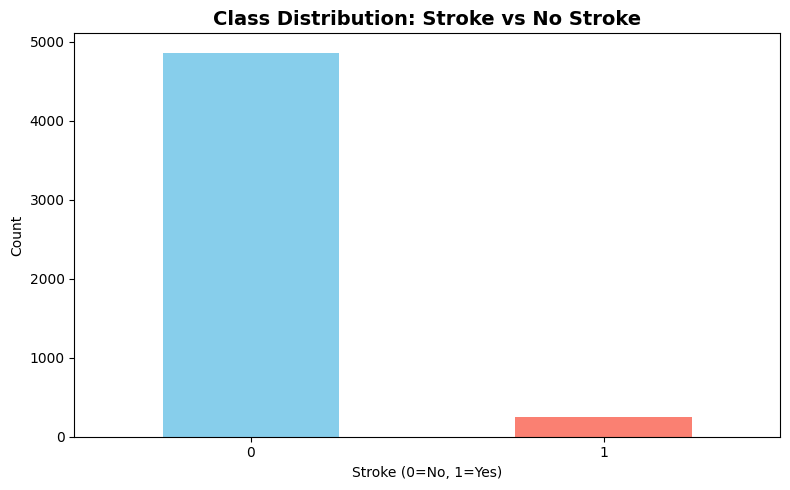

In [411]:
# Check class balance (Target variable)
print("Stroke Distribution:")
print(df['stroke'].value_counts())
print("\nStroke Percentage:")
print(df['stroke'].value_counts(normalize=True) * 100)

# Visualize class balance
plt.figure(figsize=(8, 5))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Stroke vs No Stroke', fontsize=14, fontweight='bold')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

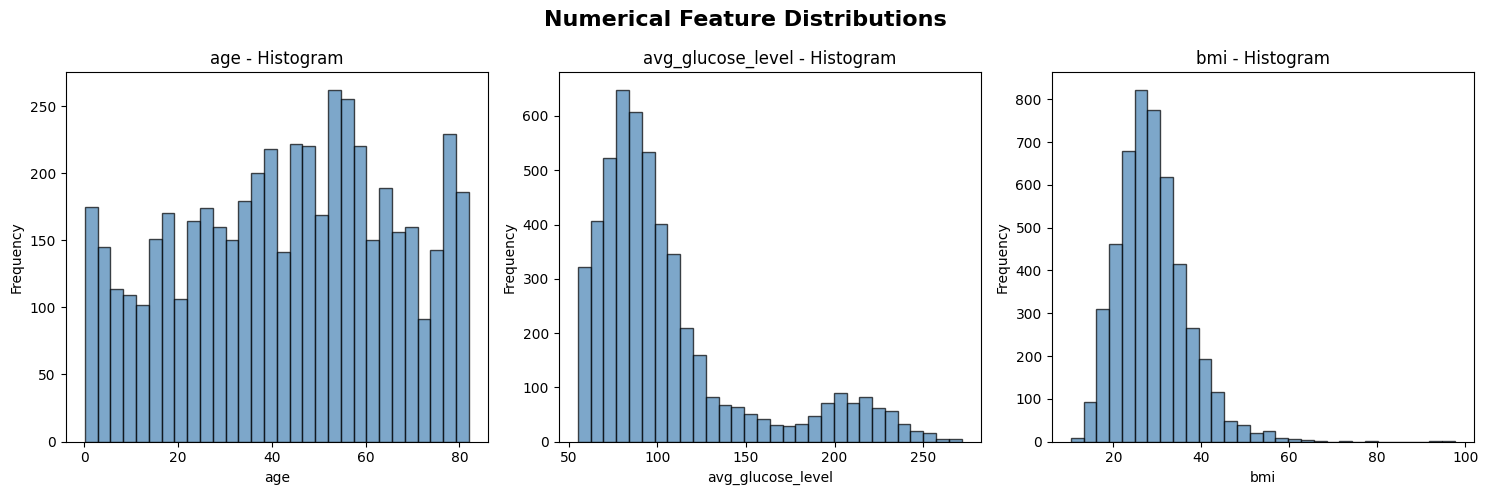

In [412]:
# Numerical Feature Distributions
numerical_features = ['age', 'avg_glucose_level', 'bmi']
num_features = len(numerical_features)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
fig.suptitle('Numerical Feature Distributions', fontsize=16, fontweight='bold')

if num_features == 1:
    axes = [axes] 

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df[feature].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} - Histogram')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



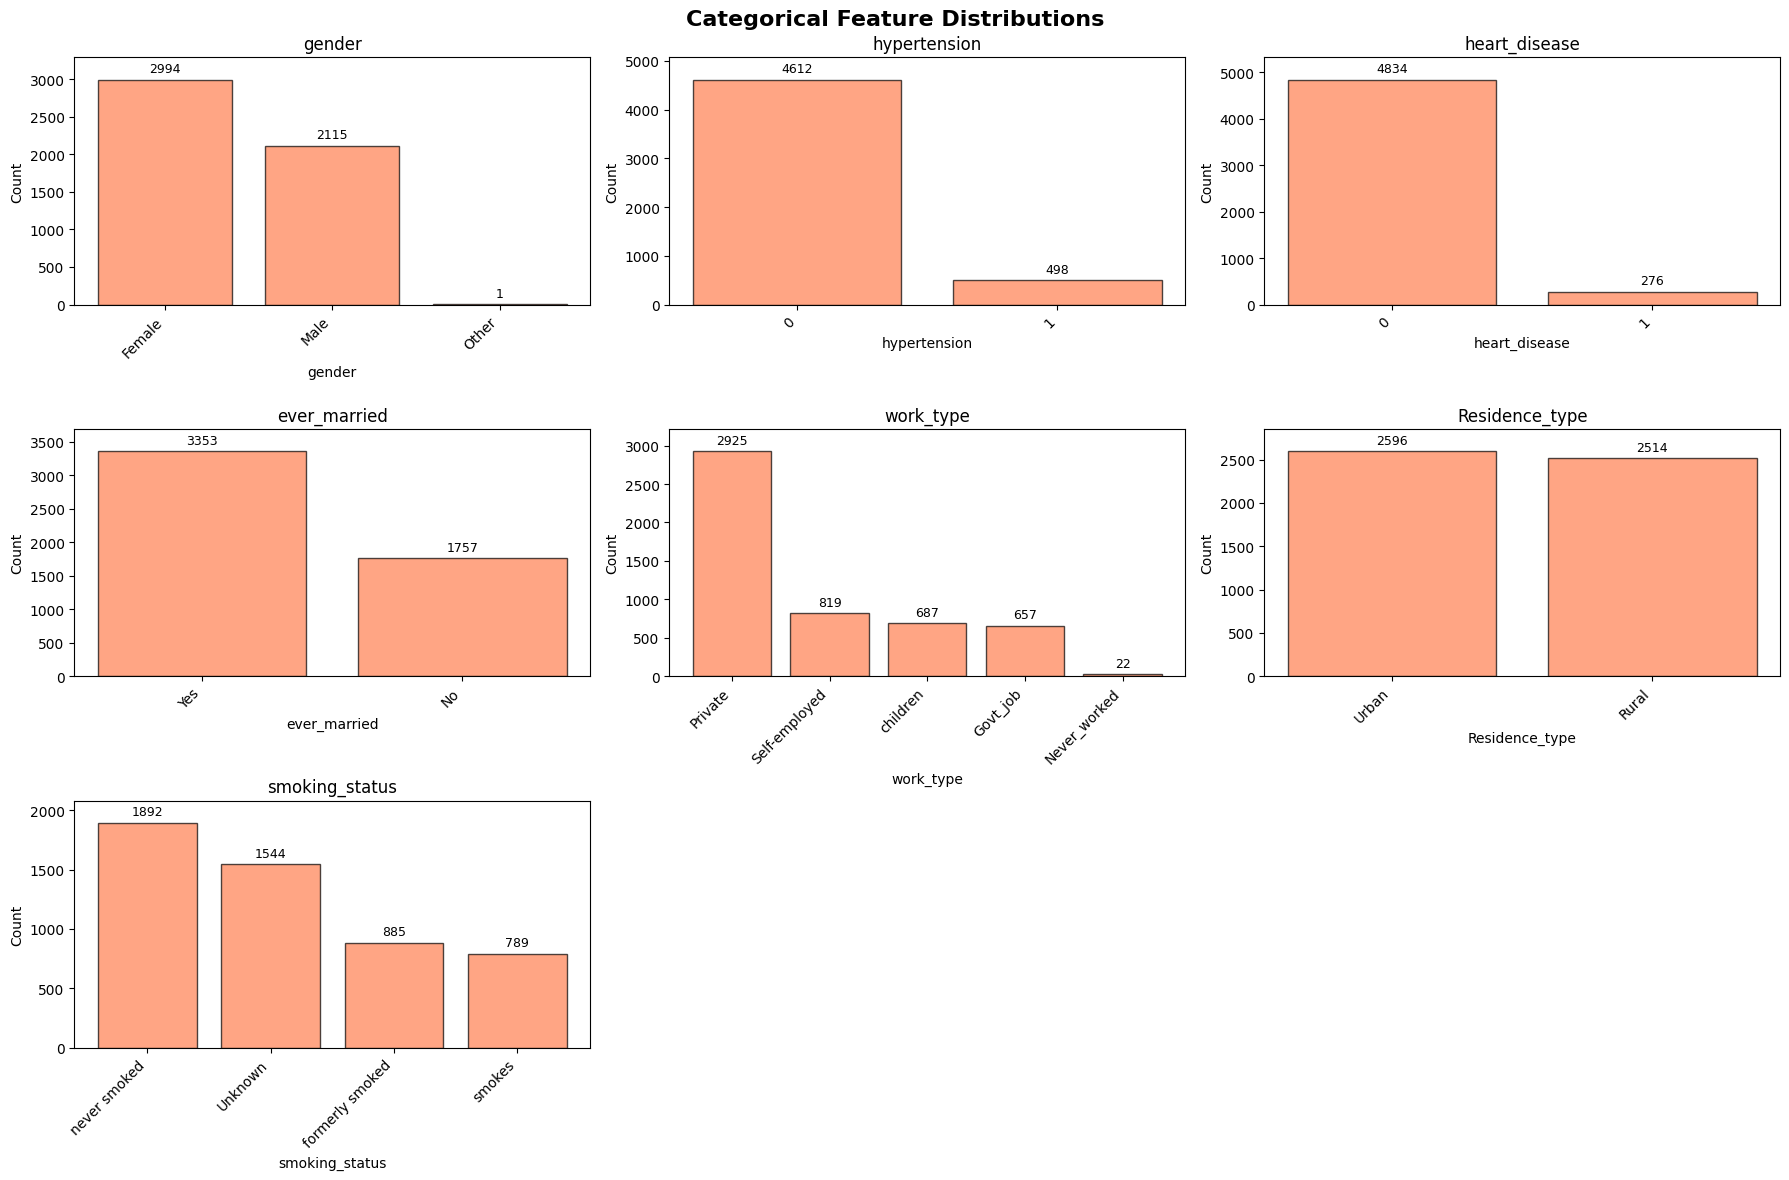

In [413]:
# Categorical Feature Distributions
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    counts = df[feature].value_counts()
    axes[idx].bar(range(len(counts)), counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    max_val = max(counts.values)
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_val * 1.1)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


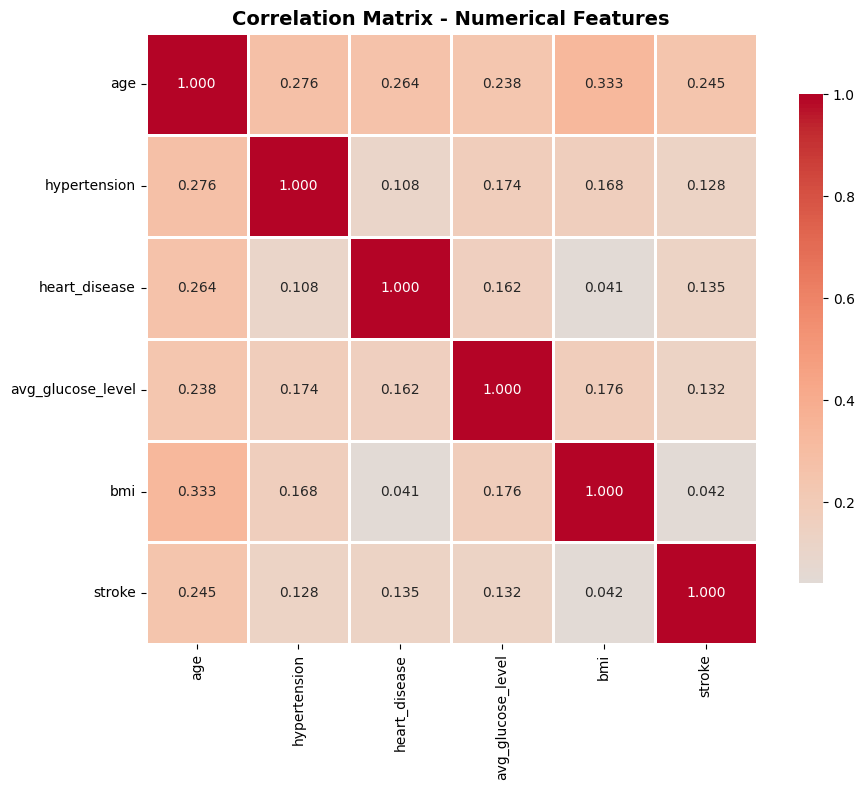


Correlations with Stroke (Target):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


In [414]:
# Correlation Matrix for Numerical Features
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelations with Stroke (Target):")
print(correlation_matrix['stroke'].sort_values(ascending=False))


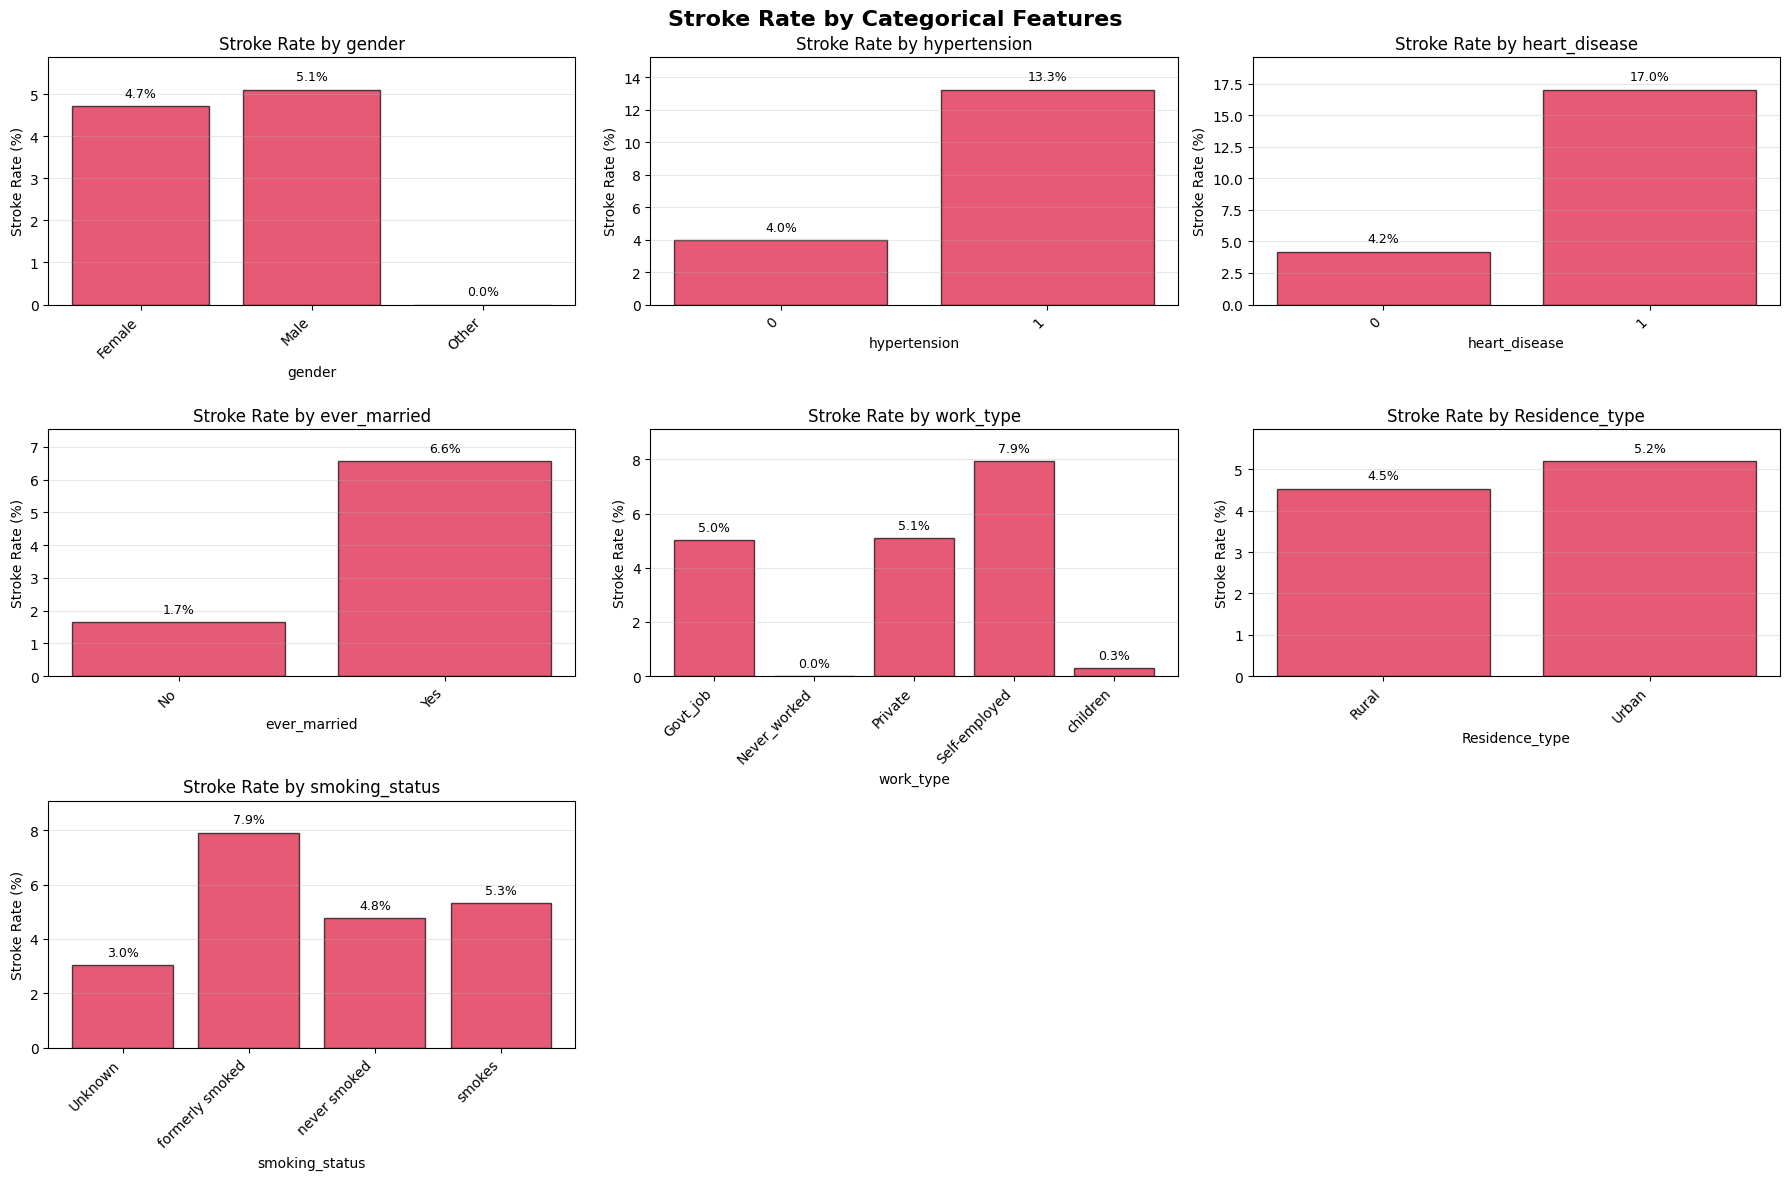

In [415]:
# Categorical Features vs Stroke 
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Stroke Rate by Categorical Features', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    # Calculate stroke rate for each category
    stroke_rate = df.groupby(feature)['stroke'].agg(['sum', 'count', 'mean'])
    stroke_rate['percentage'] = stroke_rate['mean'] * 100
    
    # Create grouped bar chart
    x = range(len(stroke_rate))
    axes[idx].bar(x, stroke_rate['percentage'], color='crimson', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Stroke Rate by {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Stroke Rate (%)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(stroke_rate.index, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    max_pct = stroke_rate['percentage'].max()
    for i, v in enumerate(stroke_rate['percentage']):
        axes[idx].text(i, v + max_pct * 0.03, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_pct * 1.15)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [416]:
# Key Observations from Initial EDA
print("KEY OBSERVATIONS FROM INITIAL ANALYSIS")

print("\n1. CLASS IMBALANCE:")
print(f"   - No Stroke: {(df['stroke']==0).sum()} ({(df['stroke']==0).sum()/len(df)*100:.1f}%)")
print(f"   - Stroke: {(df['stroke']==1).sum()} ({(df['stroke']==1).sum()/len(df)*100:.1f}%)")
print("   Highly imbalanced dataset")

print("\n2. MISSING DATA:")
print(f"   - BMI has {(df['bmi'].isna().sum()/len(df)*100):.2f}% missing values (before imputation)")
print("   - All other features are complete")

print("\n3. STRONGEST CORRELATIONS WITH STROKE:")
corr_with_stroke = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)
for feature, corr_value in corr_with_stroke.head(3).items():
    print(f"   - {feature}: {corr_value:.3f}")

print("\n4. NUMERICAL FEATURE DISTRIBUTIONS:")
print("   - Age: Right-skewed, most patients between 40-80")
print("   - Glucose: Right-skewed with some high outliers")
print("   - BMI: Approximately normal distribution")

print("\n5. CATEGORICAL FEATURE DISTRIBUTIONS:")
print(f"   - Gender: {df['gender'].value_counts()['Female']} Female ({df['gender'].value_counts()['Female']/len(df)*100:.1f}%), " +
      f"{df['gender'].value_counts()['Male']} Male ({df['gender'].value_counts()['Male']/len(df)*100:.1f}%)")
print(f"   - Hypertension: {(df['hypertension']==1).sum()} patients ({(df['hypertension']==1).sum()/len(df)*100:.1f}%) have hypertension")
print(f"   - Heart Disease: {(df['heart_disease']==1).sum()} patients ({(df['heart_disease']==1).sum()/len(df)*100:.1f}%) have heart disease")
print(f"   - Marriage: {(df['ever_married']=='Yes').sum()} patients ({(df['ever_married']=='Yes').sum()/len(df)*100:.1f}%) are married")
print(f"   - Work Type: Private sector dominates ({df['work_type'].value_counts()['Private']} patients, {df['work_type'].value_counts()['Private']/len(df)*100:.1f}%)")
print(f"   - Residence: {(df['Residence_type']=='Urban').sum()} Urban ({(df['Residence_type']=='Urban').sum()/len(df)*100:.1f}%), " +
      f"{(df['Residence_type']=='Rural').sum()} Rural ({(df['Residence_type']=='Rural').sum()/len(df)*100:.1f}%)")
smoking_counts = df['smoking_status'].value_counts()
print(f"   - Smoking Status: {smoking_counts['never smoked']} never smoked ({smoking_counts['never smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['formerly smoked']} formerly smoked ({smoking_counts['formerly smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['smokes']} smokes ({smoking_counts['smokes']/len(df)*100:.1f}%), " +
      f"{smoking_counts['Unknown']} unknown ({smoking_counts['Unknown']/len(df)*100:.1f}%)")

print("\n6. STROKE RISK BY CATEGORY (Key Risk Factors):")
hyp_stroke_rate = df[df['hypertension']==1]['stroke'].mean() * 100
no_hyp_stroke_rate = df[df['hypertension']==0]['stroke'].mean() * 100
heart_stroke_rate = df[df['heart_disease']==1]['stroke'].mean() * 100
no_heart_stroke_rate = df[df['heart_disease']==0]['stroke'].mean() * 100
married_stroke_rate = df[df['ever_married']=='Yes']['stroke'].mean() * 100
not_married_stroke_rate = df[df['ever_married']=='No']['stroke'].mean() * 100

print(f"   - Hypertension: {hyp_stroke_rate:.1f}% stroke rate (vs {no_hyp_stroke_rate:.1f}% without)")
print(f"   - Heart Disease: {heart_stroke_rate:.1f}% stroke rate (vs {no_heart_stroke_rate:.1f}% without)")
print(f"   - Ever Married: {married_stroke_rate:.1f}% stroke rate (vs {not_married_stroke_rate:.1f}% not married)")
print(f"   - Gender: Similar rates between Male ({df[df['gender']=='Male']['stroke'].mean()*100:.1f}%) " +
      f"and Female ({df[df['gender']=='Female']['stroke'].mean()*100:.1f}%)")
print(f"   - Smoking: formerly smoked ({df[df['smoking_status']=='formerly smoked']['stroke'].mean()*100:.1f}%), " +
      f"never smoked ({df[df['smoking_status']=='never smoked']['stroke'].mean()*100:.1f}%), " +
      f"smokes ({df[df['smoking_status']=='smokes']['stroke'].mean()*100:.1f}%), " +
      f"unknown ({df[df['smoking_status']=='Unknown']['stroke'].mean()*100:.1f}%)")

KEY OBSERVATIONS FROM INITIAL ANALYSIS

1. CLASS IMBALANCE:
   - No Stroke: 4861 (95.1%)
   - Stroke: 249 (4.9%)
   Highly imbalanced dataset

2. MISSING DATA:
   - BMI has 3.93% missing values (before imputation)
   - All other features are complete

3. STRONGEST CORRELATIONS WITH STROKE:
   - age: 0.245
   - heart_disease: 0.135
   - avg_glucose_level: 0.132

4. NUMERICAL FEATURE DISTRIBUTIONS:
   - Age: Right-skewed, most patients between 40-80
   - Glucose: Right-skewed with some high outliers
   - BMI: Approximately normal distribution

5. CATEGORICAL FEATURE DISTRIBUTIONS:
   - Gender: 2994 Female (58.6%), 2115 Male (41.4%)
   - Hypertension: 498 patients (9.7%) have hypertension
   - Heart Disease: 276 patients (5.4%) have heart disease
   - Marriage: 3353 patients (65.6%) are married
   - Work Type: Private sector dominates (2925 patients, 57.2%)
   - Residence: 2596 Urban (50.8%), 2514 Rural (49.2%)
   - Smoking Status: 1892 never smoked (37.0%), 885 formerly smoked (17.3%), 7

# Preprocessing

### Imputing Null Values

In [417]:
# KNN Imputation for null bmi values
imputer = KNNImputer(n_neighbors=5)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# Verify
null_percentage = df.isnull().mean() * 100
print(null_percentage)

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64


### Encoding Categorical Data

In [418]:
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int)

df_encoded = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True, dtype=int)

# Verify
df_encoded.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.893237,1,0,0,0,0,1,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,0,1,0,0,1,0
5,81.0,0,0,1,1,186.21,29.000000,1,1,0,0,1,0,0,1,0,0
6,74.0,1,1,1,0,70.09,27.400000,1,1,0,0,1,0,0,0,1,0
7,69.0,0,0,0,1,94.39,22.800000,1,0,0,0,1,0,0,0,1,0
8,59.0,0,0,1,0,76.15,28.893237,1,0,0,0,1,0,0,0,0,0
9,78.0,0,0,1,1,58.57,24.200000,1,0,0,0,1,0,0,0,0,0


### Train-Validation-Test Split

In [419]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} ({y_train.mean()*100:.2f}% stroke)")
print(f"Val: {X_val.shape[0]} ({y_val.mean()*100:.2f}% stroke)")
print(f"Test: {X_test.shape[0]} ({y_test.mean()*100:.2f}% stroke)")

Train: 3066 (4.86% stroke)
Val: 1022 (4.89% stroke)
Test: 1022 (4.89% stroke)


### Standard Scaling


In [420]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify
X_train_scaled.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1990,-1.827461,0,0,0,1,0.134857,-1.348876,1,0,0,0,0,1,0,0,0
3840,-1.297185,0,0,0,1,-0.809394,-0.611890,0,0,0,1,0,0,1,0,0
2596,0.691353,0,0,1,0,-0.602963,0.125095,0,0,0,1,0,0,0,0,0
591,0.205266,0,0,1,1,-0.463883,0.404642,1,0,0,1,0,0,0,0,1
2975,-0.457580,0,0,1,0,0.161973,1.815080,0,0,0,1,0,0,0,1,0
2170,1.486768,0,0,1,0,-0.566443,-1.221809,0,0,0,1,0,0,0,0,0
2383,0.514594,0,0,1,0,2.756586,-0.027384,1,0,0,1,0,0,0,0,0
3230,0.072697,0,0,1,1,-0.452512,1.154334,0,0,0,1,0,0,0,1,0
4565,0.558783,0,0,1,1,-0.188349,0.468175,0,0,0,0,1,0,1,0,0
4062,1.133250,0,0,1,1,-0.330271,-0.421290,0,0,0,1,0,0,1,0,0


# Exploratory & Unsupervised Analysis

### K-Means Clustering

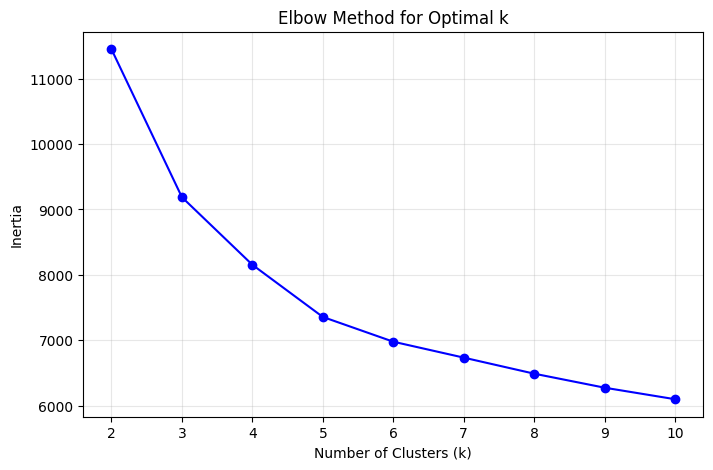

In [421]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_train_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [422]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

print("Cluster vs Stroke:")
print(pd.crosstab(clusters, y_train))

Cluster vs Stroke:
stroke     0   1
row_0           
0        855   2
1        371  57
2       1691  90


### PCA Visualization

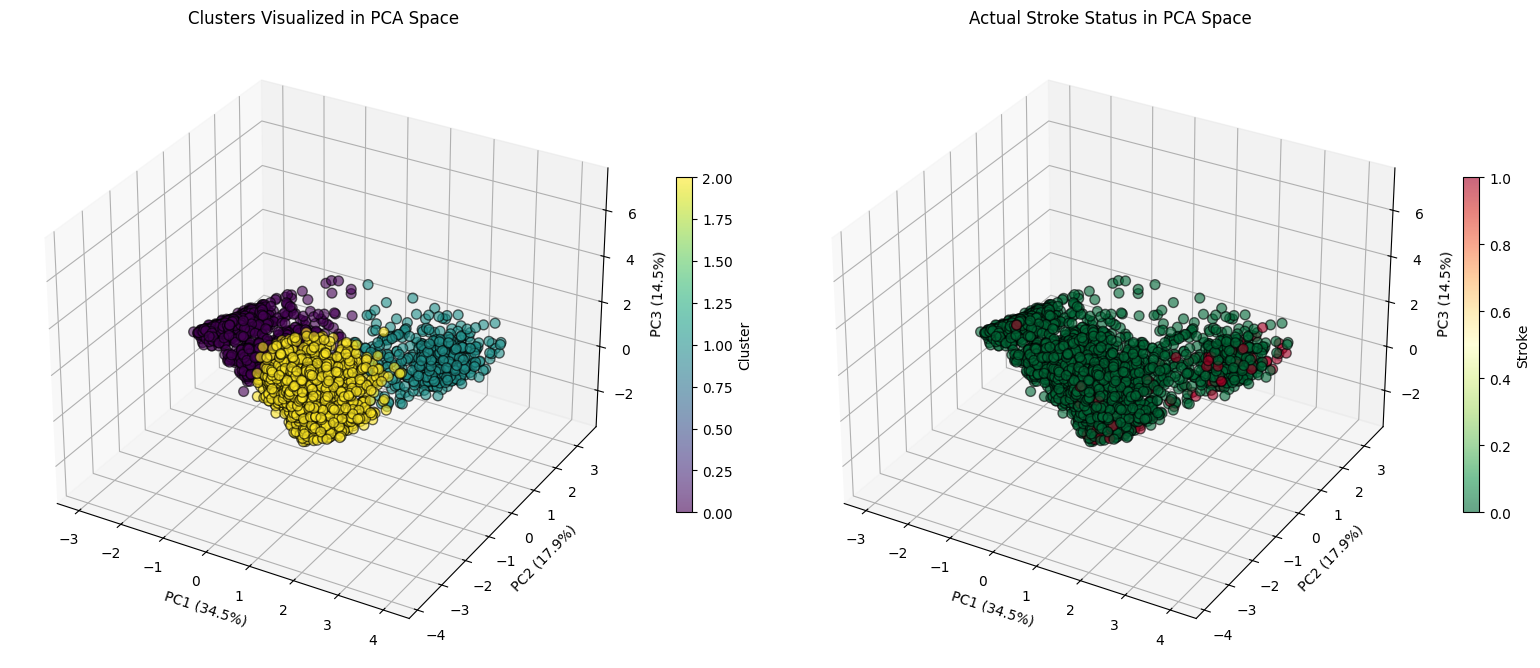

PC1 explains 34.46% of variance
PC2 explains 17.89% of variance
PC3 explains 14.47% of variance
Total: 66.82%


In [450]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(16, 7))

# 3D plot for clusters
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k', s=50)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax1.set_title('Clusters Visualized in PCA Space')
fig.colorbar(scatter1, ax=ax1, label='Cluster', shrink=0.5)

# 3D plot for stroke status
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='RdYlGn_r', alpha=0.6, edgecolors='k', s=50)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('Actual Stroke Status in PCA Space')
fig.colorbar(scatter2, ax=ax2, label='Stroke', shrink=0.5)

plt.tight_layout()
plt.show()

print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"PC3 explains {pca.explained_variance_ratio_[2]*100:.2f}% of variance")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

In [424]:
cluster_df = X_train_scaled.copy()
cluster_df['cluster'] = clusters
cluster_df['stroke'] = y_train.values

print("Cluster Characteristics (mean values):")
print(cluster_df.groupby('cluster')[numerical_cols].mean())
print("\nStroke rate by cluster:")
print(cluster_df.groupby('cluster')['stroke'].mean() * 100)


Cluster Characteristics (mean values):
              age  avg_glucose_level       bmi
cluster                                       
0       -1.235251          -0.285628 -0.843093
1        0.783759           2.154037  0.552942
2        0.406042          -0.380205  0.272808

Stroke rate by cluster:
cluster
0     0.233372
1    13.317757
2     5.053341
Name: stroke, dtype: float64


### Conlusion

During the unsupervised analysis, K-means identified three main clusters. While cluster one and cluster two had the most cases where there was a stroke (13.30% and 5.05% respectively), the majority of the strokes were still scattered throughout the data. However, cluster zero was extremely safe, containing only two cases where there was a stroke. Overall, the structure is moderate and the clusters do not separate strokes very well, suggesting missing relationships. Because of this, we will add feature additions and/or transformations in the supervised section of this notebook.

# Supervised Modeling

### Logistic Regression

In [425]:
warnings.filterwarnings('ignore')

# Testing different regularization strengths
# Smaller C = more regularization (simpler model), larger C = less regularization (more complex)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_lr = []

#### Baseline: Untransformed Data

**Rationale**: Establish a baseline using original scaled features without transformations. This allows us to see if feature engineering improves results.


In [426]:

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_scaled, y_train)
    
    train_pred = lr.predict(X_train_scaled)
    val_pred = lr.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Baseline',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    overfit_gap = train_acc - val_acc
    if overfit_gap > 0.05:
        reason = " (Overfitting - large train/val gap)"
    elif train_acc < 0.7 and val_acc < 0.7:
        reason = " (Underfitting - both low)"
    else:
        reason = ""
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}{reason}")

baseline_results = [r for r in results_lr if r['transformation'] == 'Baseline']
best_baseline = max(baseline_results, key=lambda x: x['val_f1'])
print(f"\nBest baseline: C={best_baseline['C']} with F1={best_baseline['val_f1']:.4f}")
gap = best_baseline['train_acc'] - best_baseline['val_acc']
if gap > 0.05:
    print(f"  - Overfitting (train {gap:.3f} higher than val) - will try stronger regularization")
elif best_baseline['train_acc'] < 0.75:
    print("  - Underfitting - will try adding features to capture more patterns")


C= 0.001: Train Acc=0.7179, Val Acc=0.7290, Val Prec=0.1350, Val Rec=0.8400, Val F1=0.2327
C= 0.010: Train Acc=0.7283, Val Acc=0.7329, Val Prec=0.1344, Val Rec=0.8200, Val F1=0.2310
C= 0.100: Train Acc=0.7397, Val Acc=0.7476, Val Prec=0.1414, Val Rec=0.8200, Val F1=0.2412
C= 1.000: Train Acc=0.7417, Val Acc=0.7573, Val Prec=0.1464, Val Rec=0.8200, Val F1=0.2485
C=10.000: Train Acc=0.7410, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500
C=100.000: Train Acc=0.7404, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500

Best baseline: C=10 with F1=0.2500
  - Underfitting - will try adding features to capture more patterns


#### Transformation 1: Polynomial Features (Degree 2)

**Why**: Clusters didn't separate stroke well, so maybe we need non-linear relationships. Polynomial features create combinations like age² and age×glucose. This adds lots of features, so might need stronger regularization to avoid overfitting.


In [427]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]} ({(X_train_poly.shape[1]/X_train_scaled.shape[1]):.1f}x more)")
print("Expecting lower C values to work better since we have more features now.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_poly, y_train)
    
    train_pred = lr.predict(X_train_poly)
    val_pred = lr.predict(X_val_poly)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Polynomial (deg=2)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

poly_results = [r for r in results_lr if r['transformation'] == 'Polynomial (deg=2)']
best_poly = max(poly_results, key=lambda x: x['val_f1'])
print(f"\nBest polynomial: C={best_poly['C']} with F1={best_poly['val_f1']:.4f}")
gap = best_poly['train_acc'] - best_poly['val_acc']

best_poly_model = LogisticRegression(C=best_poly['C'], max_iter=1000, random_state=42, class_weight='balanced')
best_poly_model.fit(X_train_poly, y_train)

if gap > 0.1:
    print(f"  - Bad overfitting (gap={gap:.3f}) - too many features, need stronger regularization")
elif best_poly['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_poly['val_f1']:.4f})")
    print("  - Polynomial features are helping")
else:
    print("  - No improvement - polynomial features might just be adding noise")


Original features: 16
Polynomial features: 152 (9.5x more)
Expecting lower C values to work better since we have more features now.

C= 0.001: Train Acc=0.7560, Val Acc=0.7701, Val Prec=0.1509, Val Rec=0.8000, Val F1=0.2540
C= 0.010: Train Acc=0.7538, Val Acc=0.7573, Val Prec=0.1387, Val Rec=0.7600, Val F1=0.2346
C= 0.100: Train Acc=0.7547, Val Acc=0.7564, Val Prec=0.1328, Val Rec=0.7200, Val F1=0.2243
C= 0.100: Train Acc=0.7547, Val Acc=0.7564, Val Prec=0.1328, Val Rec=0.7200, Val F1=0.2243
C= 1.000: Train Acc=0.7609, Val Acc=0.7554, Val Prec=0.1269, Val Rec=0.6800, Val F1=0.2138
C= 1.000: Train Acc=0.7609, Val Acc=0.7554, Val Prec=0.1269, Val Rec=0.6800, Val F1=0.2138
C=10.000: Train Acc=0.7590, Val Acc=0.7515, Val Prec=0.1222, Val Rec=0.6600, Val F1=0.2062
C=10.000: Train Acc=0.7590, Val Acc=0.7515, Val Prec=0.1222, Val Rec=0.6600, Val F1=0.2062
C=100.000: Train Acc=0.7564, Val Acc=0.7456, Val Prec=0.1140, Val Rec=0.6200, Val F1=0.1925

Best polynomial: C=0.001 with F1=0.2540
  - Be

#### Transformation 2: PCA Components

**Why**: PCA reduces features by keeping the important parts (85% of variance). This removes noise and might help if we're overfitting. With fewer features, we might need less regularization.


In [428]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]} (removed {X_train_scaled.shape[1] - X_train_pca.shape[1]} features)")
print(f"Kept {sum(pca_lr.explained_variance_ratio_)*100:.1f}% of variance")
print("Fewer features, so might need less regularization.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_pca, y_train)
    
    train_pred = lr.predict(X_train_pca)
    val_pred = lr.predict(X_val_pca)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'PCA (85% var)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

pca_results = [r for r in results_lr if r['transformation'] == 'PCA (85% var)']
best_pca = max(pca_results, key=lambda x: x['val_f1'])
print(f"\nBest PCA: C={best_pca['C']} with F1={best_pca['val_f1']:.4f}")
gap = best_pca['train_acc'] - best_pca['val_acc']

if best_pca['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_pca['val_f1']:.4f})")
    if gap < 0.03:
        print("  - Also reduced overfitting - PCA worked well")
else:
    print(f"  - F1 didn't improve (baseline: {best_baseline['val_f1']:.4f})")
    if gap < 0.03:
        print("  - But PCA did reduce overfitting - probably removed signal along with noise")
    else:
        print("  - Didn't help with overfitting either - removed important features")


Original features: 16
PCA components: 7 (removed 9 features)
Kept 88.7% of variance
Fewer features, so might need less regularization.

C= 0.001: Train Acc=0.7100, Val Acc=0.7182, Val Prec=0.1281, Val Rec=0.8200, Val F1=0.2216
C= 0.010: Train Acc=0.7162, Val Acc=0.7309, Val Prec=0.1359, Val Rec=0.8400, Val F1=0.2340
C= 0.100: Train Acc=0.7221, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C= 0.010: Train Acc=0.7162, Val Acc=0.7309, Val Prec=0.1359, Val Rec=0.8400, Val F1=0.2340
C= 0.100: Train Acc=0.7221, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C= 1.000: Train Acc=0.7241, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C=10.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330
C=100.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330

Best PCA: C=0.01 with F1=0.2340
  - F1 didn't improve (baseline: 0.2500)
  - But PCA did reduce overfitting - probably removed signal 

#### Transformation 3: Top Interaction Terms

**Why**: Medical knowledge says some combinations matter, like age×glucose or hypertension×heart_disease. Adding just these best interactions instead of all polynomial terms allows us to be more targeted then using all polynomial features


In [429]:
feature_names = poly.get_feature_names_out(X_train_scaled.columns)
coefficients = best_poly_model.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

interaction_terms = coef_df[coef_df['feature'].str.contains(' ')].head(20)

print("TOP 20 INTERACTION TERMS FROM POLYNOMIAL MODEL:")
for idx, row in interaction_terms.iterrows():
    print(f"{row['feature']:50s} | Coef: {row['coefficient']:8.4f}")

TOP 20 INTERACTION TERMS FROM POLYNOMIAL MODEL:
age work_type_Private                              | Coef:   0.1539
age ever_married                                   | Coef:   0.1499
age Residence_type                                 | Coef:   0.1308
age gender_Male                                    | Coef:   0.1127
age smoking_status_never smoked                    | Coef:   0.0951
age bmi                                            | Coef:  -0.0767
age smoking_status_formerly smoked                 | Coef:   0.0598
avg_glucose_level bmi                              | Coef:   0.0560
age work_type_Self-employed                        | Coef:   0.0541
avg_glucose_level work_type_Private                | Coef:   0.0520
ever_married avg_glucose_level                     | Coef:   0.0518
avg_glucose_level gender_Male                      | Coef:   0.0509
age hypertension                                   | Coef:   0.0496
age work_type_children                             | Coef:   0.0441


In [443]:
X_train_interact = X_train_scaled.copy()
X_val_interact = X_val_scaled.copy()

for idx, row in interaction_terms.iterrows():
    feature_name = row['feature']
    parts = feature_name.split(' ')
    
    if len(parts) == 2:
        feat1, feat2 = parts[0], parts[1]
        new_col_name = f"{feat1}_x_{feat2}"
        
        X_train_interact[new_col_name] = X_train_scaled[feat1] * X_train_scaled[feat2]
        X_val_interact[new_col_name] = X_val_scaled[feat1] * X_val_scaled[feat2]

print(f"\nOriginal features: {X_train_scaled.shape[1]}")
print(f"With interactions: {X_train_interact.shape[1]}")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_interact, y_train)
    
    train_pred = lr.predict(X_train_interact)
    val_pred = lr.predict(X_val_interact)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Interactions',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

interact_results = [r for r in results_lr if r['transformation'] == 'Interactions']
best_interact = max(interact_results, key=lambda x: x['val_f1'])
print(f"\nBest interactions: C={best_interact['C']} with F1={best_interact['val_f1']:.4f}")

print(f"\nComparison:")
print(f"  Baseline:           F1={best_baseline['val_f1']:.4f}")
print(f"  Polynomial (all):   F1={best_poly['val_f1']:.4f}")
print(f"  PCA:                F1={best_pca['val_f1']:.4f}")
print(f"  Interactions (20):  F1={best_interact['val_f1']:.4f}")


Original features: 16
With interactions: 33
C= 0.001: Train Acc=0.7381, Val Acc=0.7524, Val Prec=0.1413, Val Rec=0.8000, Val F1=0.2402
C= 0.010: Train Acc=0.7407, Val Acc=0.7485, Val Prec=0.1394, Val Rec=0.8000, Val F1=0.2374
C= 0.100: Train Acc=0.7420, Val Acc=0.7446, Val Prec=0.1324, Val Rec=0.7600, Val F1=0.2255
C= 1.000: Train Acc=0.7404, Val Acc=0.7348, Val Prec=0.1279, Val Rec=0.7600, Val F1=0.2190
C=10.000: Train Acc=0.7401, Val Acc=0.7368, Val Prec=0.1338, Val Rec=0.8000, Val F1=0.2292
C=100.000: Train Acc=0.7407, Val Acc=0.7358, Val Prec=0.1333, Val Rec=0.8000, Val F1=0.2286

Best interactions: C=0.001 with F1=0.2402

Comparison:
  Baseline:           F1=0.2500
  Polynomial (all):   F1=0.2540
  PCA:                F1=0.2340
  Interactions (20):  F1=0.2402


#### Results Summary Table


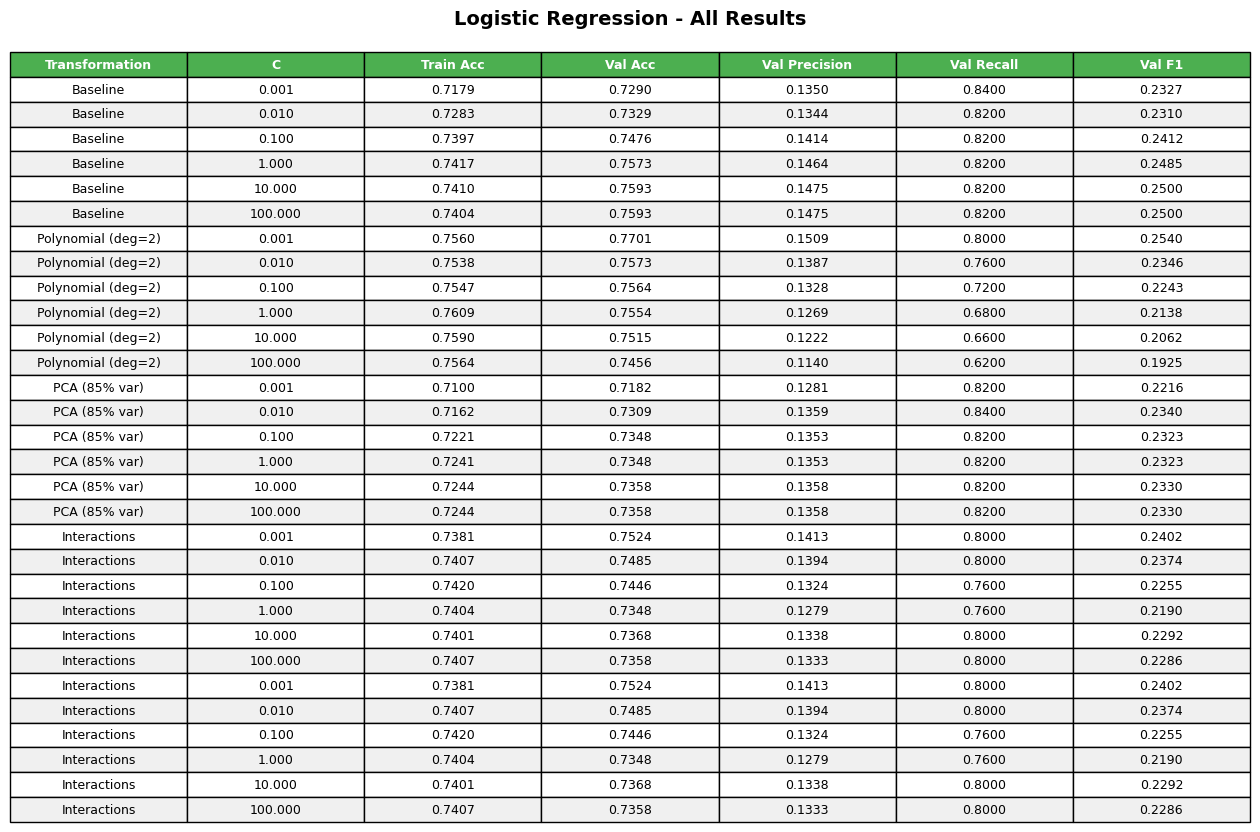


Best Model: Polynomial (deg=2) with C=0.001
  Train Acc: 0.7560, Val Acc: 0.7701
  Val Precision: 0.1509, Val Recall: 0.8000, Val F1: 0.2540


In [451]:
lr_results_df = pd.DataFrame(results_lr)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in lr_results_df.iterrows():
    table_data.append([
        row['transformation'],
        f"{row['C']:.3f}",
        f"{row['train_acc']:.4f}",
        f"{row['val_acc']:.4f}",
        f"{row['val_precision']:.4f}",
        f"{row['val_recall']:.4f}",
        f"{row['val_f1']:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Transformation', 'C', 'Train Acc', 'Val Acc', 'Val Precision', 'Val Recall', 'Val F1'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(len(table_data) + 1):
    for j in range(7):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('white')

plt.title('Logistic Regression - All Results', fontsize=14, fontweight='bold', pad=20)
plt.show()

best_overall = lr_results_df.loc[lr_results_df['val_f1'].idxmax()]
print(f"\nBest Model: {best_overall['transformation']} with C={best_overall['C']:.3f}")
print(f"  Train Acc: {best_overall['train_acc']:.4f}, Val Acc: {best_overall['val_acc']:.4f}")
print(f"  Val Precision: {best_overall['val_precision']:.4f}, Val Recall: {best_overall['val_recall']:.4f}, Val F1: {best_overall['val_f1']:.4f}")

lr_best_model = best_overall
lr_all_metrics = lr_results_df


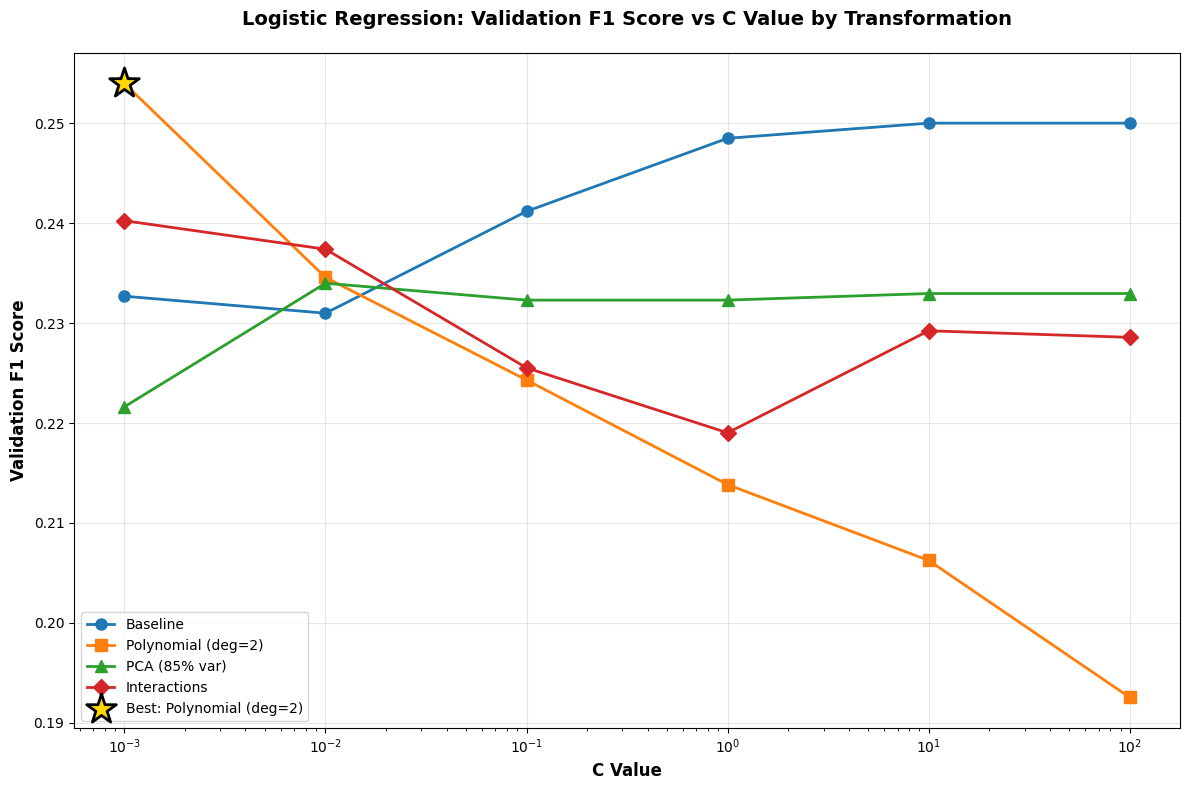

In [446]:
# Line graph: Validation F1 Score vs C Value for each transformation
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique transformations and define marker shapes
transformations = lr_results_df['transformation'].unique()
markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Find the best model overall
best_overall = lr_results_df.loc[lr_results_df['val_f1'].idxmax()]

# Plot line for each transformation
for i, transformation in enumerate(transformations):
    subset = lr_results_df[lr_results_df['transformation'] == transformation]
    subset_sorted = subset.sort_values('C')
    ax.plot(subset_sorted['C'], subset_sorted['val_f1'], 
            marker=markers[i], linewidth=2, markersize=8, 
            label=transformation, color=colors[i])

# Highlight the best model with a star
ax.scatter(best_overall['C'], best_overall['val_f1'], 
           marker='*', s=500, color='gold', edgecolors='black', linewidths=2,
           label=f"Best: {best_overall['transformation']}", zorder=5)

ax.set_xlabel('C Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression: Validation F1 Score vs C Value by Transformation', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()

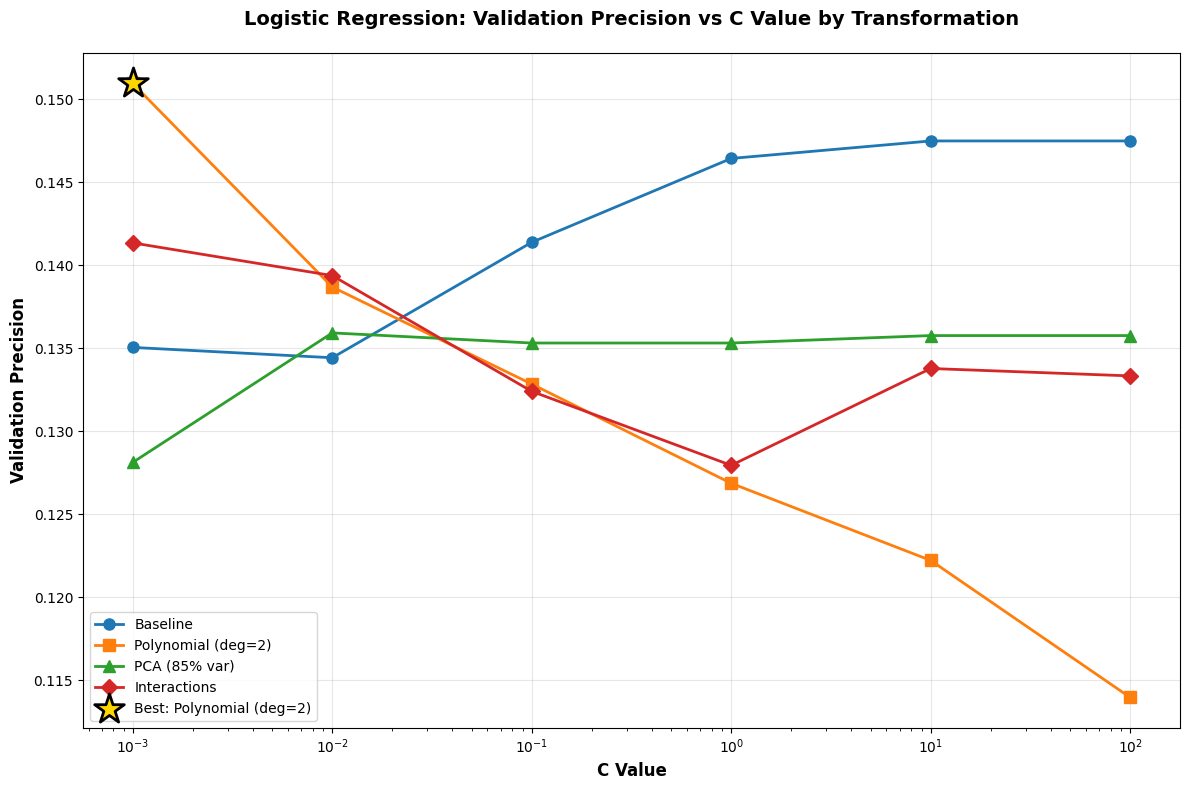

In [447]:
# Line graph: Validation Precision vs C Value for each transformation
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique transformations and define marker shapes
transformations = lr_results_df['transformation'].unique()
markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Find the best model by precision
best_precision = lr_results_df.loc[lr_results_df['val_precision'].idxmax()]

# Plot line for each transformation
for i, transformation in enumerate(transformations):
    subset = lr_results_df[lr_results_df['transformation'] == transformation]
    subset_sorted = subset.sort_values('C')
    ax.plot(subset_sorted['C'], subset_sorted['val_precision'], 
            marker=markers[i], linewidth=2, markersize=8, 
            label=transformation, color=colors[i])

# Highlight the best model with a star
ax.scatter(best_precision['C'], best_precision['val_precision'], 
           marker='*', s=500, color='gold', edgecolors='black', linewidths=2,
           label=f"Best: {best_precision['transformation']}", zorder=5)

ax.set_xlabel('C Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Precision', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression: Validation Precision vs C Value by Transformation', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()

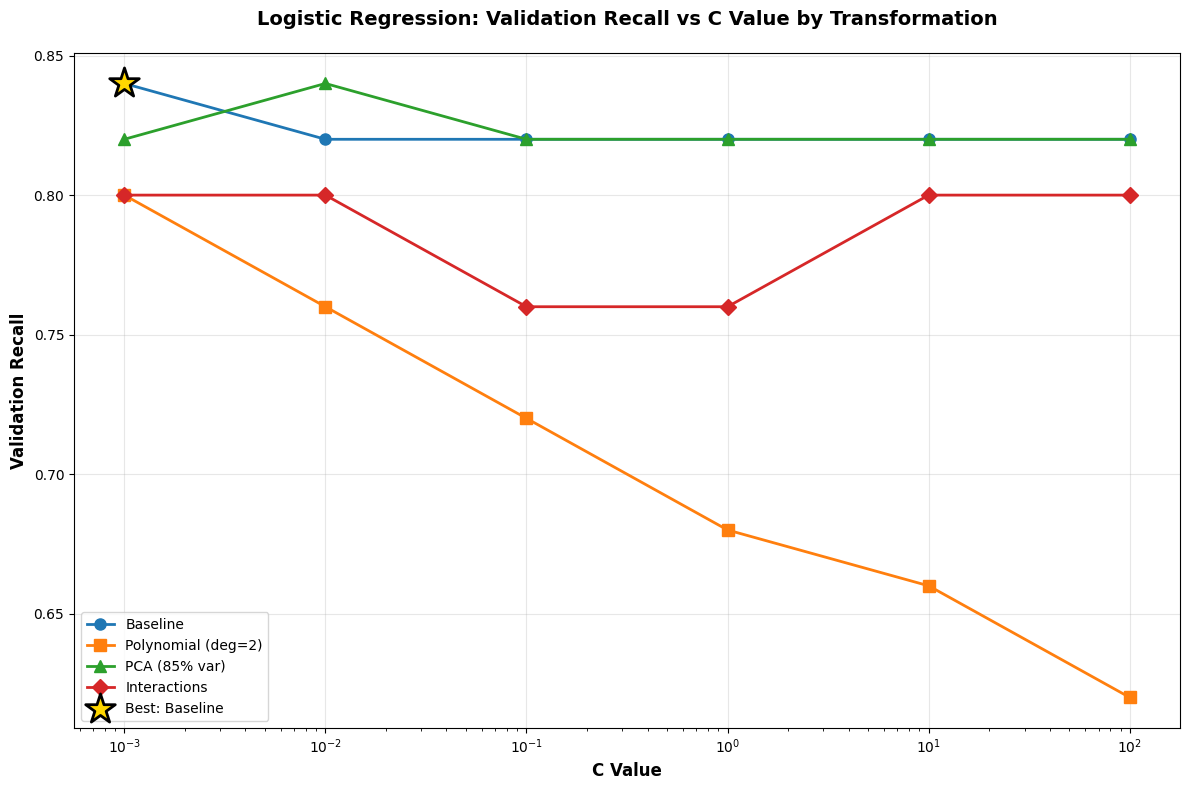

In [448]:
# Line graph: Validation Recall vs C Value for each transformation
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique transformations and define marker shapes
transformations = lr_results_df['transformation'].unique()
markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Find the best model by recall
best_recall = lr_results_df.loc[lr_results_df['val_recall'].idxmax()]

# Plot line for each transformation
for i, transformation in enumerate(transformations):
    subset = lr_results_df[lr_results_df['transformation'] == transformation]
    subset_sorted = subset.sort_values('C')
    ax.plot(subset_sorted['C'], subset_sorted['val_recall'], 
            marker=markers[i], linewidth=2, markersize=8, 
            label=transformation, color=colors[i])

# Highlight the best model with a star
ax.scatter(best_recall['C'], best_recall['val_recall'], 
           marker='*', s=500, color='gold', edgecolors='black', linewidths=2,
           label=f"Best: {best_recall['transformation']}", zorder=5)

ax.set_xlabel('C Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Recall', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression: Validation Recall vs C Value by Transformation', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
plt.tight_layout()
plt.show()

### Supervised Method 2: KNN

In [432]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#https://scikit-learn.org/stable/modules/model_evaluation.html

k_values = [1, 2, 3, 5, 7, 11]
#k_values = range(1, 21)

def run_knn(X_train, y_train, X_val, y_val, k_values, weighted=0):
    results = []
    for k in k_values:

        if weighted==1:
            #distance weight - minkowski p=2 / euclidean distance 
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        else:
            #default to uniform weight
            knn = KNeighborsClassifier(n_neighbors=k)

        #fit the model 
        knn.fit(X_train, y_train)

        #compute predictions
        y_pred_train = knn.predict(X_train) #training set predictions
        y_pred_val = knn.predict(X_val) # validation set predictions

        #compute performance metrics 
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        acc_train = accuracy_score(y_train, y_pred_train) #training accuracy
        acc_val = accuracy_score(y_val, y_pred_val) #validation accuracy 
        precision_val = precision_score(y_val, y_pred_val, zero_division = 0)
        recall_val = recall_score(y_val, y_pred_val, zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, zero_division=0)
        fnr_val = fn / (tp + fn) if (tp + fn) != 0 else 1 
            
        #add to results list
        results.append({
            "k": k,
            "Training Accuracy": acc_train,
            "Validation Accuracy": acc_val,
            "Precision": precision_val,
            "Recall": recall_val,
            "F1": f1_val,
            "FNR": fnr_val,
            "TP": tp,
            "TN": tn,
            "FN": fn,
            "FP":fp
        })
        
        # identify overfitting / underfitting 
        overfit_gap = acc_train - acc_val
        if overfit_gap > 0.05:
            reason = " (Overfitting — boundary too sharp)"
        elif acc_train < 0.7 and acc_val < 0.7:
            reason = " (Underfitting — decision boundary too smooth)"
        else:
            reason = ""

        # print summary 
        print(
            f"k={k:2d}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, "
            f"Prec={precision_val:.4f}, Rec/TPR={recall_val:.4f}, F1={f1_val:.4f}, "
            f"FNR={fnr_val:.4f}{reason}, "
            f"TP={tp}, FP={fp}, FN={fn}, TN={tn}"
        )
    return pd.DataFrame(results)


def choose_best_k(results_df):
    #find the row with the highest F1 score - choose this as the best K
    best_idx = results_df["F1"].idxmax()
    best_row = results_df.loc[best_idx]

    print("\n BEST KNN MODEL ")
    print(
        f"Best k = {best_row['k']} "
        f"with F1={best_row['F1']:.4f} "
        f"and FNR={best_row['FNR']:.4f}"
    )
    gap = best_row["Training Accuracy"] - best_row["Validation Accuracy"]

    if gap > 0.05:
        print("→ Overfitting detected ")
    elif best_row["Training Accuracy"] < 0.75:
        print("→ Underfitting detected")
    else:
        print("→ Balanced")
    return best_row
    

Baseline (No Feature Transformations)

In [433]:

k_results_baseline1 = run_knn(X_train_scaled, y_train, X_val_scaled, y_val, k_values, weighted=0 )
best_k_baseline1 = choose_best_k(k_results_baseline1)
k_results_baseline2 = run_knn(X_train_scaled, y_train, X_val_scaled, y_val, k_values, weighted=1 )
best_k_baseline2 = choose_best_k(k_results_baseline2)

k= 1: Train Acc=1.0000, Val Acc=0.9168, Prec=0.0930, Rec/TPR=0.0800, F1=0.0860, FNR=0.9200 (Overfitting — boundary too sharp), TP=4, FP=39, FN=46, TN=933
k= 2: Train Acc=0.9563, Val Acc=0.9472, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=4, FN=50, TN=968
k= 2: Train Acc=0.9563, Val Acc=0.9472, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=4, FN=50, TN=968
k= 3: Train Acc=0.9563, Val Acc=0.9452, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=6, FN=50, TN=966
k= 3: Train Acc=0.9563, Val Acc=0.9452, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=6, FN=50, TN=966
k= 5: Train Acc=0.9511, Val Acc=0.9501, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=1, FN=50, TN=971
k= 5: Train Acc=0.9511, Val Acc=0.9501, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=1, FN=50, TN=971
k= 7: Train Acc=0.9517, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 7: Train Acc=0.95

When using uniform weights, for all values of k tried except for k=1,the precision, recall, F1, and TPR were all 0. This indicates that the model is never predicting the the positive class. Using distance based weight, these metrics are non-zero for k=1 to k=3, but comparing the training accuracy and validation accuracy suggests that the distance based weight model is more prone to overfitting. In both models, the minimum number of false negatives was 46 , and only 4 true positives in those models. This further suggests that the model is doing poorly at predicting the positive class. Since the models with the minimum FN's are the same as the ones with the best F1 scores, k=1 for both. 

So far, it appears that KNN is performing very poorly on this dataset. 

Polynomial Feature Transformation



Reasoning for Transformation: KNN on the untransfomred data showed poor performance and poor ability to detect the positive class , having a high proportion of false negatives. Adding polynomial transformation may help capture non-linear patterns / relationships between numerical features. 
    

In [434]:
# copy the data before transforming
X_train_poly = X_train_scaled.copy()
X_val_poly = X_val_scaled.copy()
X_test_poly = X_test_scaled.copy()

# transform all the numerical features
for df in [X_train_poly, X_val_poly, X_test_poly]:
    df['age_sq'] = df['age'] ** 2
    df['glucose_sq'] = df['avg_glucose_level'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']


In [435]:
# run knn w uniform weight
poly_k_results_uniform = run_knn(X_train_poly, y_train, X_val_poly, y_val, k_values, weighted=0)
best_poly_k_uniform = choose_best_k(poly_k_results_uniform)

#run knn w distance weight
poly_k_results_distance = run_knn(X_train_poly, y_train, X_val_poly, y_val, k_values, weighted=1)
best_poly_k_distance = choose_best_k(poly_k_results_distance)


k= 1: Train Acc=1.0000, Val Acc=0.9119, Prec=0.1429, Rec/TPR=0.1600, F1=0.1509, FNR=0.8400 (Overfitting — boundary too sharp), TP=8, FP=48, FN=42, TN=924
k= 2: Train Acc=0.9560, Val Acc=0.9462, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=5, FN=50, TN=967
k= 3: Train Acc=0.9569, Val Acc=0.9432, Prec=0.1000, Rec/TPR=0.0200, F1=0.0333, FNR=0.9800, TP=1, FP=9, FN=49, TN=963
k= 3: Train Acc=0.9569, Val Acc=0.9432, Prec=0.1000, Rec/TPR=0.0200, F1=0.0333, FNR=0.9800, TP=1, FP=9, FN=49, TN=963
k= 5: Train Acc=0.9514, Val Acc=0.9511, Prec=0.5000, Rec/TPR=0.0200, F1=0.0385, FNR=0.9800, TP=1, FP=1, FN=49, TN=971
k= 5: Train Acc=0.9514, Val Acc=0.9511, Prec=0.5000, Rec/TPR=0.0200, F1=0.0385, FNR=0.9800, TP=1, FP=1, FN=49, TN=971
k= 7: Train Acc=0.9517, Val Acc=0.9491, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=2, FN=50, TN=970
k= 7: Train Acc=0.9517, Val Acc=0.9491, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=2, FN=50, TN=970
k=11: Train Acc=0.95

After applying polynomial transformations, there was a slight increase in true positives for k=1, and a decrease in false negatives. The f1 score nearly doubled as well. The model is still performing very badly but the polynomial transformation did seem to help to an extent. 

It is still difficult to say if uniform or distance weight is better, since the performance of the distance weighted model seems to decrease less immediately for larger k values, but also seems more prone to overfitting than the uniform weighted model. 


Transformatiom #2: Adding Categorical Interaction Features

Reasoning for Transformation choice: the polynomial feature transformations only included numerical features, which is only 3 features. Looking at the interactions between certain categorical and numerical features could capture relationships that might have more impact on stroke risk than just looking at those features alone. 
    

In [436]:
def add_interactions(df):
    df = df.copy()
    df['female'] = 1 - df['gender_Male'] - df.get('gender_Other', 0)
    df = df.drop(columns=[col for col in ['gender_Male', 'gender_Other'] if col in df.columns])

    #df['female_former_smoker'] = df['female'] * df['smoking_status_formerly smoked']
    df['female_current_smoker'] = df['female'] * df['smoking_status_smokes']
    #df['married_urban'] = df['ever_married'] * df['Residence_type']
    #df['married_female'] = df['ever_married'] * df['female']

    df['age_hypertension'] = df['age'] * df['hypertension']
    df['age_heart_disease'] = df['age'] * df['heart_disease']

    return df


In [437]:
X_train_inter = add_interactions(X_train_scaled)
X_val_inter = add_interactions(X_val_scaled)
X_test_inter = add_interactions(X_test_scaled)

#X_train_inter[['female_former_smoker','female_current_smoker','married_urban',
               #'married_female','age_hypertension','age_heart_disease']].head()



In [438]:
results_inter_uniform = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=0
)
best_inter_uniform = choose_best_k(results_inter_uniform)

# Distance weight
results_inter_distance = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=1
)
best_inter_distance = choose_best_k(results_inter_distance)

k= 1: Train Acc=1.0000, Val Acc=0.9178, Prec=0.1304, Rec/TPR=0.1200, F1=0.1250, FNR=0.8800 (Overfitting — boundary too sharp), TP=6, FP=40, FN=44, TN=932
k= 2: Train Acc=0.9569, Val Acc=0.9472, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=4, FN=50, TN=968
k= 2: Train Acc=0.9569, Val Acc=0.9472, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=4, FN=50, TN=968
k= 3: Train Acc=0.9576, Val Acc=0.9442, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=7, FN=50, TN=965
k= 3: Train Acc=0.9576, Val Acc=0.9442, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=7, FN=50, TN=965
k= 5: Train Acc=0.9527, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 5: Train Acc=0.9527, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 7: Train Acc=0.9514, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 7: Train Acc=0.95

The interactions alone did worse than the polynomial transformations, but were still a slight improvement from the baseline. Will try adding categorical interactions on top of the polynomial transformed data. 

In [439]:
X_train_inter_poly = add_interactions(X_train_poly)
X_val_inter_poly = add_interactions(X_val_poly)
X_test_inter_poly = add_interactions(X_test_poly)

results_inter_poly_uniform = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=0
)
best_inter_poly_uniform = choose_best_k(results_inter_poly_uniform)

# Distance weight
results_inter_poly_distance = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=1
)
best_inter_poly_distance = choose_best_k(results_inter_poly_distance)


k= 1: Train Acc=1.0000, Val Acc=0.9178, Prec=0.1304, Rec/TPR=0.1200, F1=0.1250, FNR=0.8800 (Overfitting — boundary too sharp), TP=6, FP=40, FN=44, TN=932
k= 2: Train Acc=0.9569, Val Acc=0.9472, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=4, FN=50, TN=968
k= 3: Train Acc=0.9576, Val Acc=0.9442, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=7, FN=50, TN=965
k= 3: Train Acc=0.9576, Val Acc=0.9442, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=7, FN=50, TN=965
k= 5: Train Acc=0.9527, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 5: Train Acc=0.9527, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 7: Train Acc=0.9514, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k= 7: Train Acc=0.9514, Val Acc=0.9511, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=0, FN=50, TN=972
k=11: Train Acc=0.95

Layering polynomial + interactions did no better than interactions alone, and was worse than polynomial by itself

Transformation 3: PCA Transform 

Reasoning for transformation: 

In [440]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]} (removed {X_train_scaled.shape[1] - X_train_pca.shape[1]} features)")
print(f"Kept {sum(pca_lr.explained_variance_ratio_)*100:.1f}% of variance")
print("Fewer features, so might need less regularization.\n")

results_knn_pca_uniform = run_knn(
    X_train_pca, y_train,
    X_val_pca, y_val,
    k_values,
    weighted=0
)
best_knn_pca_uniform = choose_best_k(results_knn_pca_uniform)

results_knn_pca_distance = run_knn(
    X_train_pca, y_train,
    X_val_pca, y_val,
    k_values,
    weighted=1
)
best_knn_pca_distance = choose_best_k(results_knn_pca_distance)


Original features: 16
PCA components: 7 (removed 9 features)
Kept 88.7% of variance
Fewer features, so might need less regularization.

k= 1: Train Acc=1.0000, Val Acc=0.9100, Prec=0.1379, Rec/TPR=0.1600, F1=0.1481, FNR=0.8400 (Overfitting — boundary too sharp), TP=8, FP=50, FN=42, TN=922
k= 2: Train Acc=0.9592, Val Acc=0.9442, Prec=0.1111, Rec/TPR=0.0200, F1=0.0339, FNR=0.9800, TP=1, FP=8, FN=49, TN=964
k= 3: Train Acc=0.9583, Val Acc=0.9374, Prec=0.0625, Rec/TPR=0.0200, F1=0.0303, FNR=0.9800, TP=1, FP=15, FN=49, TN=957
k= 5: Train Acc=0.9537, Val Acc=0.9491, Prec=0.2500, Rec/TPR=0.0200, F1=0.0370, FNR=0.9800, TP=1, FP=3, FN=49, TN=969
k= 3: Train Acc=0.9583, Val Acc=0.9374, Prec=0.0625, Rec/TPR=0.0200, F1=0.0303, FNR=0.9800, TP=1, FP=15, FN=49, TN=957
k= 5: Train Acc=0.9537, Val Acc=0.9491, Prec=0.2500, Rec/TPR=0.0200, F1=0.0370, FNR=0.9800, TP=1, FP=3, FN=49, TN=969
k= 7: Train Acc=0.9511, Val Acc=0.9501, Prec=0.0000, Rec/TPR=0.0000, F1=0.0000, FNR=1.0000, TP=0, FP=1, FN=50, TN=971


KNN Results Table 

KNN Results

Transformation            Weighting    k      Training Accuracy Validation Accuracy Precision    Recall     F1       FNR      TP    FP    FN    TN   
--------------------------------------------------------------------------------------------------------------------------------------------
Categorical Interactions  Distance     1      1.0000     0.9178     0.1304       0.1200     0.1250   0.8800   6     40    44    932  
Categorical Interactions  Distance     2      1.0000     0.9178     0.1304       0.1200     0.1250   0.8800   6     40    44    932  
Categorical Interactions  Distance     3      1.0000     0.9403     0.0769       0.0200     0.0317   0.9800   1     12    49    960  
Categorical Interactions  Distance     5      1.0000     0.9472     0.0000       0.0000     0.0000   1.0000   0     4     50    968  
Categorical Interactions  Distance     7      1.0000     0.9491     0.0000       0.0000     0.0000   1.0000   0     2     50    970  
Categorical Interactions  

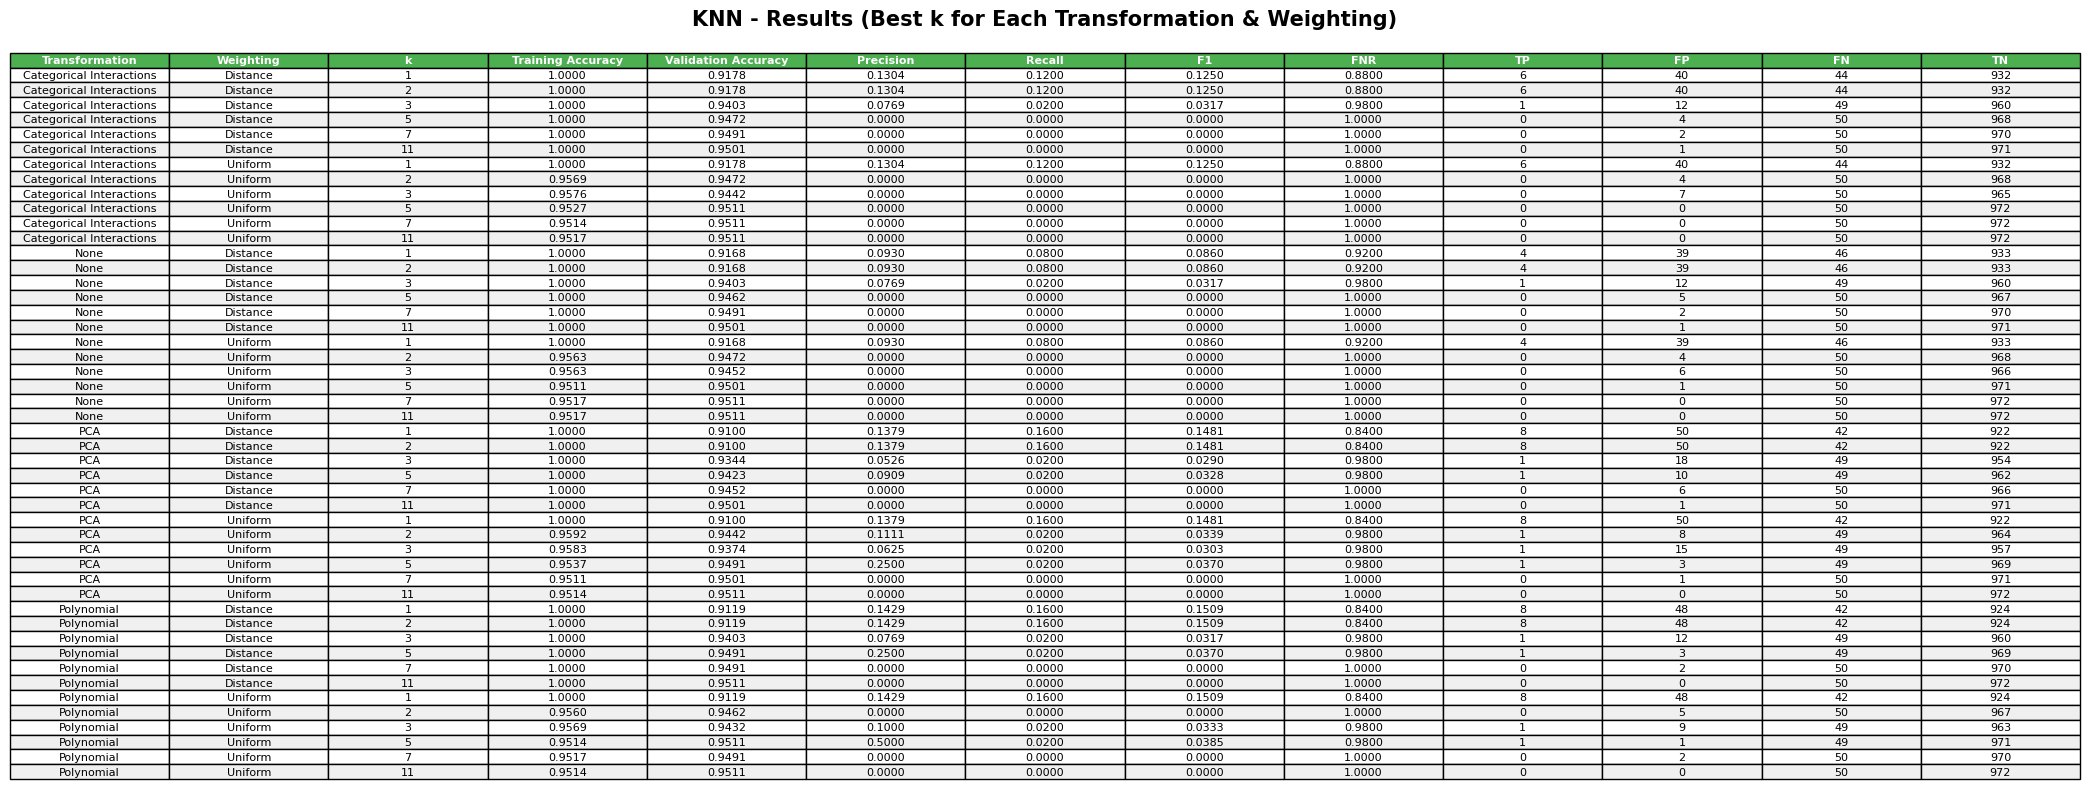

In [441]:
def attach_labels(df, name, weighting):
    df = df.copy()
    df["Transformation"] = name
    df["Weighting"] = weighting
    return df

knn_all_results = pd.concat([
    attach_labels(k_results_baseline1, "None", "Uniform"),
    attach_labels(k_results_baseline2, "None", "Distance"),
    attach_labels(poly_k_results_uniform, "Polynomial", "Uniform"),
    attach_labels(poly_k_results_distance, "Polynomial", "Distance"),
    attach_labels(results_inter_uniform, "Categorical Interactions", "Uniform"),
    attach_labels(results_inter_distance, "Categorical Interactions", "Distance"),
    attach_labels(results_knn_pca_uniform, "PCA", "Uniform"),
    attach_labels(results_knn_pca_distance, "PCA", "Distance"),
], ignore_index=True)

knn_all_results = knn_all_results.sort_values(["Transformation", "Weighting", "k"])
knn_results_df = pd.DataFrame(knn_all_results)


print("KNN Results")
print("=" * 140)
print(f"\n{'Transformation':<25} {'Weighting':<12} {'k':<6} {'Training Accuracy':<10} {'Validation Accuracy':<10} "
      f"{'Precision':<12} {'Recall':<10} {'F1':<8} {'FNR':<8} {'TP':<5} {'FP':<5} {'FN':<5} {'TN':<5}")
print("-" * 140)

for _, row in knn_results_df.iterrows():
    print(f"{row['Transformation']:<25} {row['Weighting']:<12} {int(row['k']):<6} "
          f"{row['Training Accuracy']:<10.4f} {row['Validation Accuracy']:<10.4f} {row['Precision']:<12.4f} "
          f"{row['Recall']:<10.4f} {row['F1']:<8.4f} {row['FNR']:<8.4f} "
          f"{int(row['TP']):<5} {int(row['FP']):<5} {int(row['FN']):<5} {int(row['TN']):<5}")

print("=" * 140)

fig, ax = plt.subplots(figsize=(21, 8))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in knn_results_df.iterrows():
    table_data.append([
        row['Transformation'],
        row['Weighting'],
        int(row['k']),
        f"{row['Training Accuracy']:.4f}",
        f"{row['Validation Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1']:.4f}",
        f"{row['FNR']:.4f}",
        int(row['TP']),
        int(row['FP']),
        int(row['FN']),
        int(row['TN'])
    ])
column_labels = ['Transformation', 'Weighting', 'k', 'Training Accuracy', 'Validation Accuracy', 'Precision', 'Recall', 'F1', 'FNR', 'TP', 'FP', 'FN', 'TN']
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

# Highlight best row (highest F1)
best_idx = knn_results_df['F1'].idxmax()
highlight_row = knn_results_df.index.get_loc(best_idx)

for i in range(0, len(table_data) + 1): 
    for j in range(len(column_labels)):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        elif (i % 2) == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')
plt.title('KNN - Results (Best k for Each Transformation & Weighting)', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



### Supervised Method 3: Neural Network (using Keras)

In [442]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # model - stacked layers
from tensorflow.keras.layers import Dense #fully connected layer 
from tensorflow.keras.regularizers import l2 #regularization 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #metrics 
from sklearn.utils.class_weight import compute_class_weight #calculates how to balance classes 
import numpy as np
import pandas as pd

# weight classes to help w imbalance
"""
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)
"""

def run_keras_nn(X_train, y_train, X_val, y_val, alpha_values, transformation_name="Baseline"):
    results = []

    for alpha in alpha_values:
        model = Sequential([
            Dense(4, activation='relu', kernel_regularizer=l2(alpha), input_shape=(X_train.shape[1],)),
            Dense(2, activation='relu', kernel_regularizer=l2(alpha)),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            epochs=30, #iters 
            batch_size=32,
            verbose=0,
            #class_weight=class_weights_dict
        )


        # Predictions
        y_probs_val = model.predict(X_val).flatten()
        y_pred_val = (y_probs_val > 0.5).astype(int)
        y_probs_train = model.predict(X_train).flatten()
        y_pred_train = (y_probs_train > 0.5).astype(int)


        train_acc = accuracy_score(y_train, y_pred_train)
        val_acc = accuracy_score(y_val, y_pred_val)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        precision_val = precision_score(y_val, y_pred_val, zero_division=0)
        recall_val = recall_score(y_val, y_pred_val, zero_division=0)
        fnr = fn / (tp + fn) if (tp + fn) != 0 else 1
        f1_val = f1_score(y_val, y_pred_val, zero_division=0)


        results.append({
            "transformation": transformation_name,
            "alpha": alpha,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "val_precision": precision_val,
            "val_recall": recall_val,
            "val_f1": f1_val,
            "FNR": fnr,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn
        })

        print(f"Alpha={alpha:.1e} | "
              f"Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | "
              f"P={precision_val:.4f} R={recall_val:.4f} F1={f1_val:.4f} FNR={fnr:.4f} TP={tp} FN={fn} FP={fp} TN={tn}")

    return pd.DataFrame(results)
def choose_best_nn(results_df):
    best_idx = results_df["val_f1"].idxmax()
    best_row = results_df.loc[best_idx]
    
    print("\n BEST NN MODEL ")
    print(f"Transformation: {best_row['transformation']}")
    print(f"alpha={best_row['alpha']:.1e} | F1={best_row['val_f1']:.4f} | FNR={best_row['FNR']:.4f}")
    
    return best_row





ModuleNotFoundError: No module named 'tensorflow'

When running the neural network with no class weighting, 

No Transformations

In [ ]:

alpha_values = [0, 1e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

nn_baseline_results = run_keras_nn(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    alpha_values,
    transformation_name="Baseline"
)
best_nn_baseline = choose_best_nn(nn_baseline_results)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
Alpha=0.0e+00 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Alpha=1.0e-06 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Alpha=1.0e-05 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
Alpha=3.0e-05 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
Alpha=1.0e-04 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 

With no transformations, the neural network is performing much better than KNN, achieving similar F1 scores but much lower FNR and much less overfitting / gap between the training and validation accuracy

Transformation 1: Polynomial Feature Transformation

Reasoning: the baseline neural network shows much higher recall than many of the previous models tried, but shows very low precision. Adding polynomial transformation might help create a more complex decision boundary and improve the model's precision while maintaining a good recall. 

In [ ]:
# create the transformed data
X_train_poly = X_train_scaled.copy()
X_val_poly = X_val_scaled.copy()
X_test_poly = X_test_scaled.copy()

for df in [X_train_poly, X_val_poly, X_test_poly]:
    df['age_sq'] = df['age'] ** 2
    df['glucose_sq'] = df['avg_glucose_level'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']

In [ ]:
nn_poly_results = run_keras_nn(
    X_train_poly, y_train,
    X_val_poly, y_val,
    alpha_values,
    transformation_name="Polynomial"
)

best_nn_poly = choose_best_nn(nn_poly_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
Alpha=0.0e+00 | Train Acc=0.9537 | Val Acc=0.9501 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=1 TN=971
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
Alpha=1.0e-06 | Train Acc=0.9579 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
Alpha=1.0e-05 | Train Acc=0.9540 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
Alpha=3.0e-05 | Train Acc=0.9547 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
Alpha=1.0e-04 | Train Acc=0.9563 | Val Acc=0.9501 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=1 TN=971
32/32 ━━━━━━━━━━━━━━━━━━━

Adding polynomial transformed features to the data improved the F1 score slightly, but raised the FNR and increased the gap between training and validation accuracy. Although the F1 score did slightly improve, I would say that the polynomial transformation did not help or perform better than the baseline

Transformation 2: PCA

In [ ]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

nn_pca_results = run_keras_nn(
    X_train_pca, y_train,
    X_val_pca, y_val,
    alpha_values,
    transformation_name="PCA Transform"
)
best_nn_pca = choose_best_nn(nn_pca_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
Alpha=0.0e+00 | Train Acc=0.9517 | Val Acc=0.9501 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=1 TN=971
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
Alpha=1.0e-06 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
Alpha=1.0e-05 | Train Acc=0.9521 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
Alpha=3.0e-05 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
Alpha=1.0e-04 | Train Acc=0.9514 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━

Reasoning : 

Transformation 3: Category Interactions

In [ ]:
X_train_inter = add_interactions(X_train_scaled)
X_val_inter = add_interactions(X_val_scaled)
X_test_inter = add_interactions(X_test_scaled)

In [ ]:
nn_inter_results = run_keras_nn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    alpha_values,
    transformation_name="Interactions"
)
best_nn_inter = choose_best_nn(nn_inter_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
Alpha=0.0e+00 | Train Acc=0.9566 | Val Acc=0.9501 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=1 TN=971
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Alpha=1.0e-06 | Train Acc=0.9553 | Val Acc=0.9501 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=1 TN=971
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
Alpha=1.0e-05 | Train Acc=0.9540 | Val Acc=0.9511 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=0 TN=972
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
Alpha=3.0e-05 | Train Acc=0.9556 | Val Acc=0.9491 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=2 TN=970
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
Alpha=1.0e-04 | Train Acc=0.9550 | Val Acc=0.9491 | P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000 TP=0 FN=50 FP=2 TN=970
32/32 ━━━━━━━━━━━━━━━━━

NEURAL NETWORK (KERAS) - COMPLETE RESULTS TABLE

Transformation            Alpha (λ)       Train Acc    Val Acc      Val Prec     Val Recall   Val F1       FNR          TP     FP     FN     TN    
--------------------------------------------------------------------------------------------------------------------------------------------
Baseline                  0.00e+00        0.9553       0.9511       0.0000       0.0000       0.0000       1.0000       0      0      50     972   
Baseline                  1.00e-06        0.9556       0.9491       0.0000       0.0000       0.0000       1.0000       0      2      50     970   
Baseline                  1.00e-05        0.9537       0.9501       0.0000       0.0000       0.0000       1.0000       0      1      50     971   
Baseline                  3.00e-05        0.9547       0.9511       0.0000       0.0000       0.0000       1.0000       0      0      50     972   
Baseline                  1.00e-04        0.9530       0.9511       0.

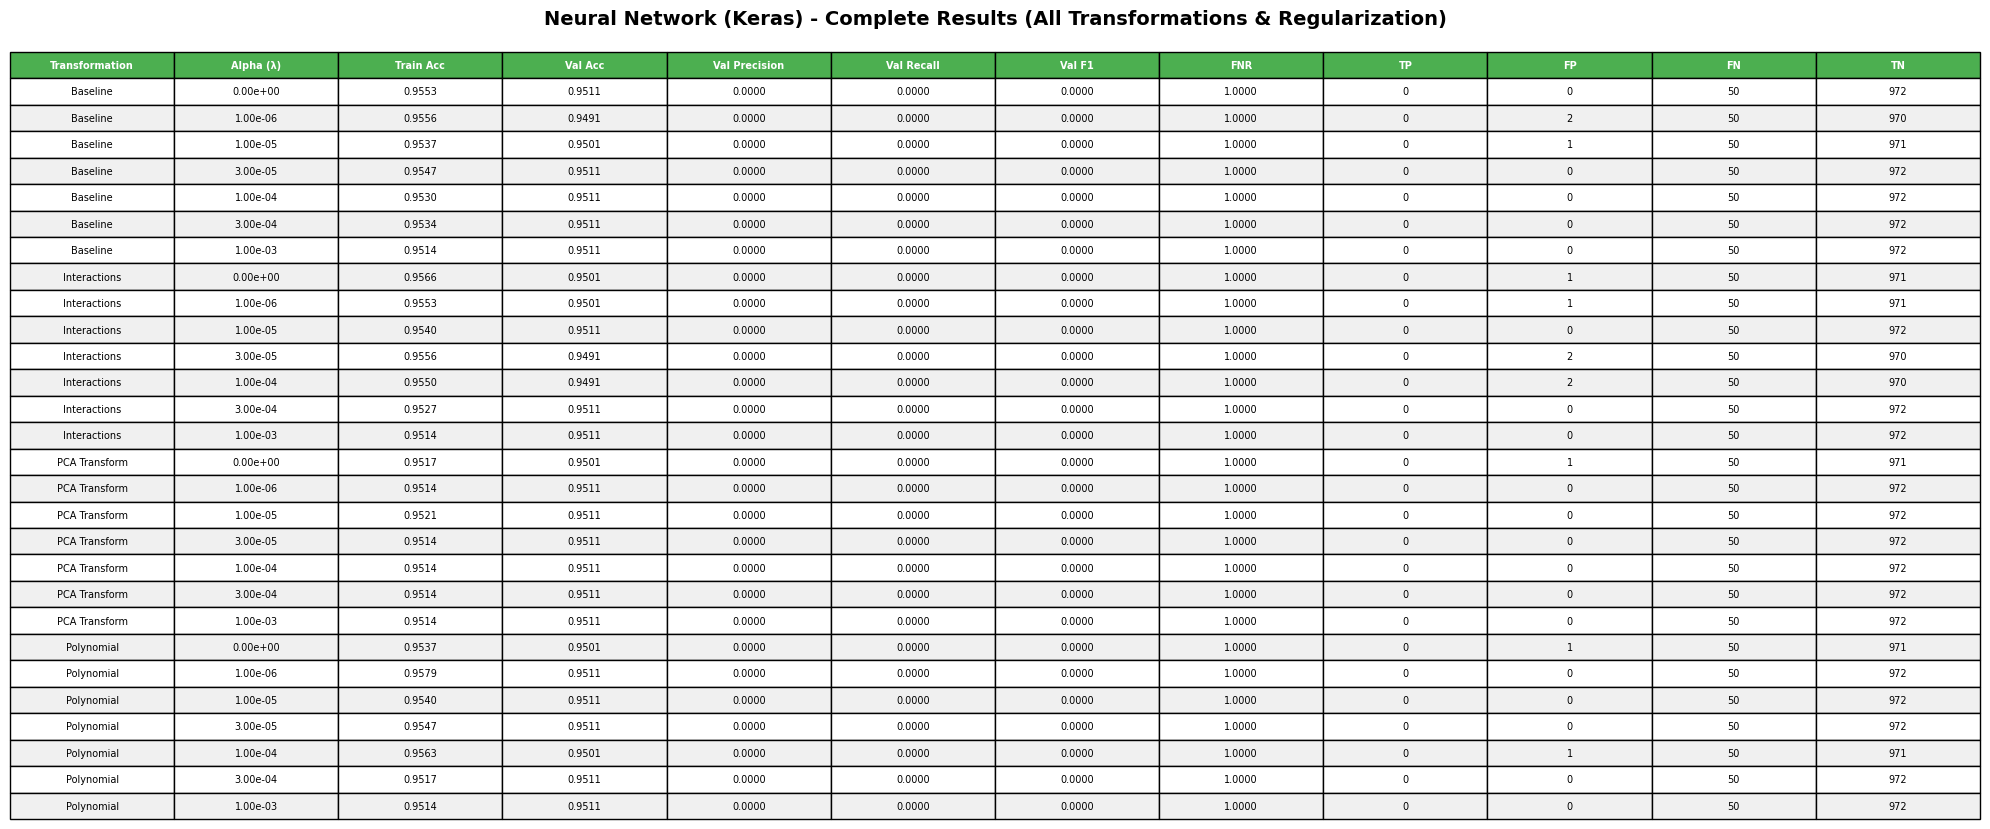


BEST NEURAL NETWORK MODEL:
  Transformation: Baseline
  Alpha (λ): 0.00e+00
  Train Acc: 0.9553
  Val Acc: 0.9511
  Val Precision: 0.0000
  Val Recall: 0.0000
  Val F1: 0.0000
  FNR: 1.0000
  TP: 0, FP: 0, FN: 50, TN: 972


In [ ]:
nn_all_results = []

for _, row in nn_baseline_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'FNR': row['FNR'],
            'TP': row['TP'],
            'FP': row['FP'],
            'FN': row['FN'],
            'TN': row['TN']
        })

for _, row in nn_poly_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'FNR': row['FNR'],
            'TP': row['TP'],
            'FP': row['FP'],
            'FN': row['FN'],
            'TN': row['TN']
        })

for _, row in nn_pca_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'FNR': row['FNR'],
            'TP': row['TP'],
            'FP': row['FP'],
            'FN': row['FN'],
            'TN': row['TN']
        })


for _, row in nn_inter_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'FNR': row['FNR'],
            'TP': row['TP'],
            'FP': row['FP'],
            'FN': row['FN'],
            'TN': row['TN']
        })

if nn_all_results:
    nn_results_df = pd.DataFrame(nn_all_results)
    nn_results_df = nn_results_df.sort_values(['Transformation', 'Alpha'])
    
    print("=" * 140)
    print("NEURAL NETWORK (KERAS) - COMPLETE RESULTS TABLE")
    print("=" * 140)
    print(f"\n{'Transformation':<25} {'Alpha (λ)':<15} {'Train Acc':<12} {'Val Acc':<12} "
          f"{'Val Prec':<12} {'Val Recall':<12} {'Val F1':<12} {'FNR':<12} {'TP':<6} {'FP':<6} {'FN':<6} {'TN':<6}")
    print("-" * 140)
    
    for _, row in nn_results_df.iterrows():
        print(f"{row['Transformation']:<25} {row['Alpha']:<15.2e} {row['Train Acc']:<12.4f} "
              f"{row['Val Acc']:<12.4f} {row['Val Precision']:<12.4f} {row['Val Recall']:<12.4f} "
              f"{row['Val F1']:<12.4f} {row['FNR']:<12.4f} {int(row['TP']):<6} {int(row['FP']):<6} "
              f"{int(row['FN']):<6} {int(row['TN']):<6}")
    
    print("=" * 140)

    fig, ax = plt.subplots(figsize=(20, max(8, len(nn_results_df) * 0.3)))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for _, row in nn_results_df.iterrows():
        table_data.append([
            row['Transformation'],
            f"{row['Alpha']:.2e}",
            f"{row['Train Acc']:.4f}",
            f"{row['Val Acc']:.4f}",
            f"{row['Val Precision']:.4f}",
            f"{row['Val Recall']:.4f}",
            f"{row['Val F1']:.4f}",
            f"{row['FNR']:.4f}",
            int(row['TP']),
            int(row['FP']),
            int(row['FN']),
            int(row['TN'])
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Transformation', 'Alpha (λ)', 'Train Acc', 'Val Acc',
                              'Val Precision', 'Val Recall', 'Val F1', 'FNR', 'TP', 'FP', 'FN', 'TN'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 1.5)
    
    for i in range(len(table_data) + 1):
        for j in range(12):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif i % 2 == 0:
                cell.set_facecolor('#f0f0f0')
            else:
                cell.set_facecolor('white')
    
    plt.title('Neural Network (Keras) - Complete Results (All Transformations & Regularization)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    best_nn = nn_results_df.loc[nn_results_df['Val F1'].idxmax()]
    print(f"\n{'='*140}")
    print(f"BEST NEURAL NETWORK MODEL:")
    print(f"  Transformation: {best_nn['Transformation']}")
    print(f"  Alpha (λ): {best_nn['Alpha']:.2e}")
    print(f"  Train Acc: {best_nn['Train Acc']:.4f}")
    print(f"  Val Acc: {best_nn['Val Acc']:.4f}")
    print(f"  Val Precision: {best_nn['Val Precision']:.4f}")
    print(f"  Val Recall: {best_nn['Val Recall']:.4f}")
    print(f"  Val F1: {best_nn['Val F1']:.4f}")
    print(f"  FNR: {best_nn['FNR']:.4f}")
    print(f"  TP: {int(best_nn['TP'])}, FP: {int(best_nn['FP'])}, FN: {int(best_nn['FN'])}, TN: {int(best_nn['TN'])}")
    print("=" * 140)
else:
    print("Neural Network results not found. Please run the NN cells first.")


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

C_values = [0.01, 0.1, 1, 10, 50, 100]
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

def run_svm(X_train, y_train, X_val, y_val, transformation_name="None"):
    results = []

    for C in C_values:
        for gamma in gamma_values:
            svm = SVC(kernel='rbf', C=C, gamma=gamma)
            svm.fit(X_train, y_train)

            y_pred_val = svm.predict(X_val)
            y_pred_train = svm.predict(X_train)

            tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_val)
            precision_val = precision_score(y_val, y_pred_val, zero_division=0)
            recall_val = recall_score(y_val, y_pred_val, zero_division=0)
            f1_val = f1_score(y_val, y_pred_val, zero_division=0)
            fnr_val = fn / (tp + fn) if (tp + fn) != 0 else 1

            results.append({
                "transformation": transformation_name,
                "C": C,
                "gamma": gamma,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "precision": precision_val,
                "recall": recall_val,
                "f1": f1_val,
                "FNR": fnr_val,
                "TP": tp, "FP": fp, "FN": fn, "TN": tn
            })

            print(f"SVM C={C:>5}, gamma={gamma:<7} | TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} "
                  f"P={precision_val:.4f} R={recall_val:.4f} F1={f1_val:.4f} FNR={fnr_val:.4f}")

    return pd.DataFrame(results)

def choose_best_svm(results_df):
    best_idx = results_df["f1"].idxmax()
    best_row = results_df.loc[best_idx]

    print("\n BEST SVM MODEL ")
    print(f"Transformation: {best_row['transformation']}")
    print(f"C={best_row['C']} | gamma={best_row['gamma']}")
    print(f"F1={best_row['f1']:.4f} | Recall={best_row['recall']:.4f} | FNR={best_row['FNR']:.4f}")
    print(f"TP={best_row['TP']}  FP={best_row['FP']}  FN={best_row['FN']}  TN={best_row['TN']}")

    gap = best_row["train_acc"] - best_row["val_acc"]
    if gap > 0.05:
        print("→ Overfitting detected (complex boundary — high C or high gamma)")
    elif best_row["train_acc"] < 0.75:
        print("→ Underfitting detected (decision boundary too simple)")
    else:
        print("→ Balanced model")
    
    return best_row


No Transformations:

In [ ]:
svm_baseline_results = run_svm(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    transformation_name="None"
)
best_svm_baseline = choose_best_svm(svm_baseline_results)

SVM C= 0.01, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.5     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=1       | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000


Polynomial Transform

In [ ]:
X_train_poly = X_train_scaled.copy()
X_val_poly = X_val_scaled.copy()
X_test_poly = X_test_scaled.copy()

for df in [X_train_poly, X_val_poly, X_test_poly]:
    df['age_sq'] = df['age'] ** 2
    df['glucose_sq'] = df['avg_glucose_level'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']

In [ ]:
svm_poly_results = run_svm(
    X_train_poly, y_train,
    X_val_poly, y_val,
    transformation_name="None"
)
best_svm_baseline = choose_best_svm(svm_poly_results)

SVM C= 0.01, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.5     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=1       | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000


Transformation 2: PCA Components

In [ ]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

svm_pca_results = run_svm(
    X_train_pca, y_train,
    X_val_pca, y_val,
    transformation_name="PCA Transform"
)
best_svm_pca = choose_best_svm(svm_pca_results)

SVM C= 0.01, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.5     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=1       | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000


Transformation 3: Category Interaction

In [ ]:
X_train_inter = add_interactions(X_train_scaled)
X_val_inter = add_interactions(X_val_scaled)
X_test_inter = add_interactions(X_test_scaled)

In [ ]:
svm_inter_results = run_svm(
    X_train_inter, y_train,
    X_val_inter, y_val,
    transformation_name="Interactions"
)
best_svm_inter = choose_best_svm(svm_inter_results)

SVM C= 0.01, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=0.5     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C= 0.01, gamma=1       | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.0001  | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.001   | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.01    | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000
SVM C=  0.1, gamma=0.1     | TrainAcc=0.9514 | ValAcc=0.9511 P=0.0000 R=0.0000 F1=0.0000 FNR=1.0000


Best Configuration : 
PCA Component Transform with C=100, gamma = 1

Results:
F1=0.1852 | Recall=0.2000 | FNR=0.8000
TP=10  FP=48  FN=40  TN=924

In [ ]:
svm_all_results = []

def append_svm_results(df):
    for _, row in df.iterrows():
        svm_all_results.append({
            'Transformation': row['transformation'],
            'C': row['C'],
            'gamma': row['gamma'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Precision': row['precision'],
            'Recall': row['recall'],
            'F1': row['f1'],
            'FNR': row['FNR'],
            'TP': row['TP'],
            'FP': row['FP'],
            'FN': row['FN'],
            'TN': row['TN']
        })

append_svm_results(svm_baseline_results)
append_svm_results(svm_poly_results)
append_svm_results(svm_pca_results)
append_svm_results(svm_inter_results)

svm_results_df = pd.DataFrame(svm_all_results)
svm_results_df = svm_results_df.sort_values(['Transformation', 'C', 'gamma'])


SVM Results

Transformation     C        gamma      TrainAcc   ValAcc    Precision  Recall     F1         FNR        TP    FP    FN    TN   
------------------------------------------------------------------------------------------------------------------------------------------------------
Interactions       0.01     0.0001     0.9514     0.9511     0.0000     0.0000     0.0000     1.0000     0     0     50    972  
Interactions       0.01     0.001      0.9514     0.9511     0.0000     0.0000     0.0000     1.0000     0     0     50    972  
Interactions       0.01     0.01       0.9514     0.9511     0.0000     0.0000     0.0000     1.0000     0     0     50    972  
Interactions       0.01     0.1        0.9514     0.9511     0.0000     0.0000     0.0000     1.0000     0     0     50    972  
Interactions       0.01     0.5        0.9514     0.9511     0.0000     0.0000     0.0000     1.0000     0     0     50    972  
Interactions       0.01     1.0        0.9514     0.9511     0.

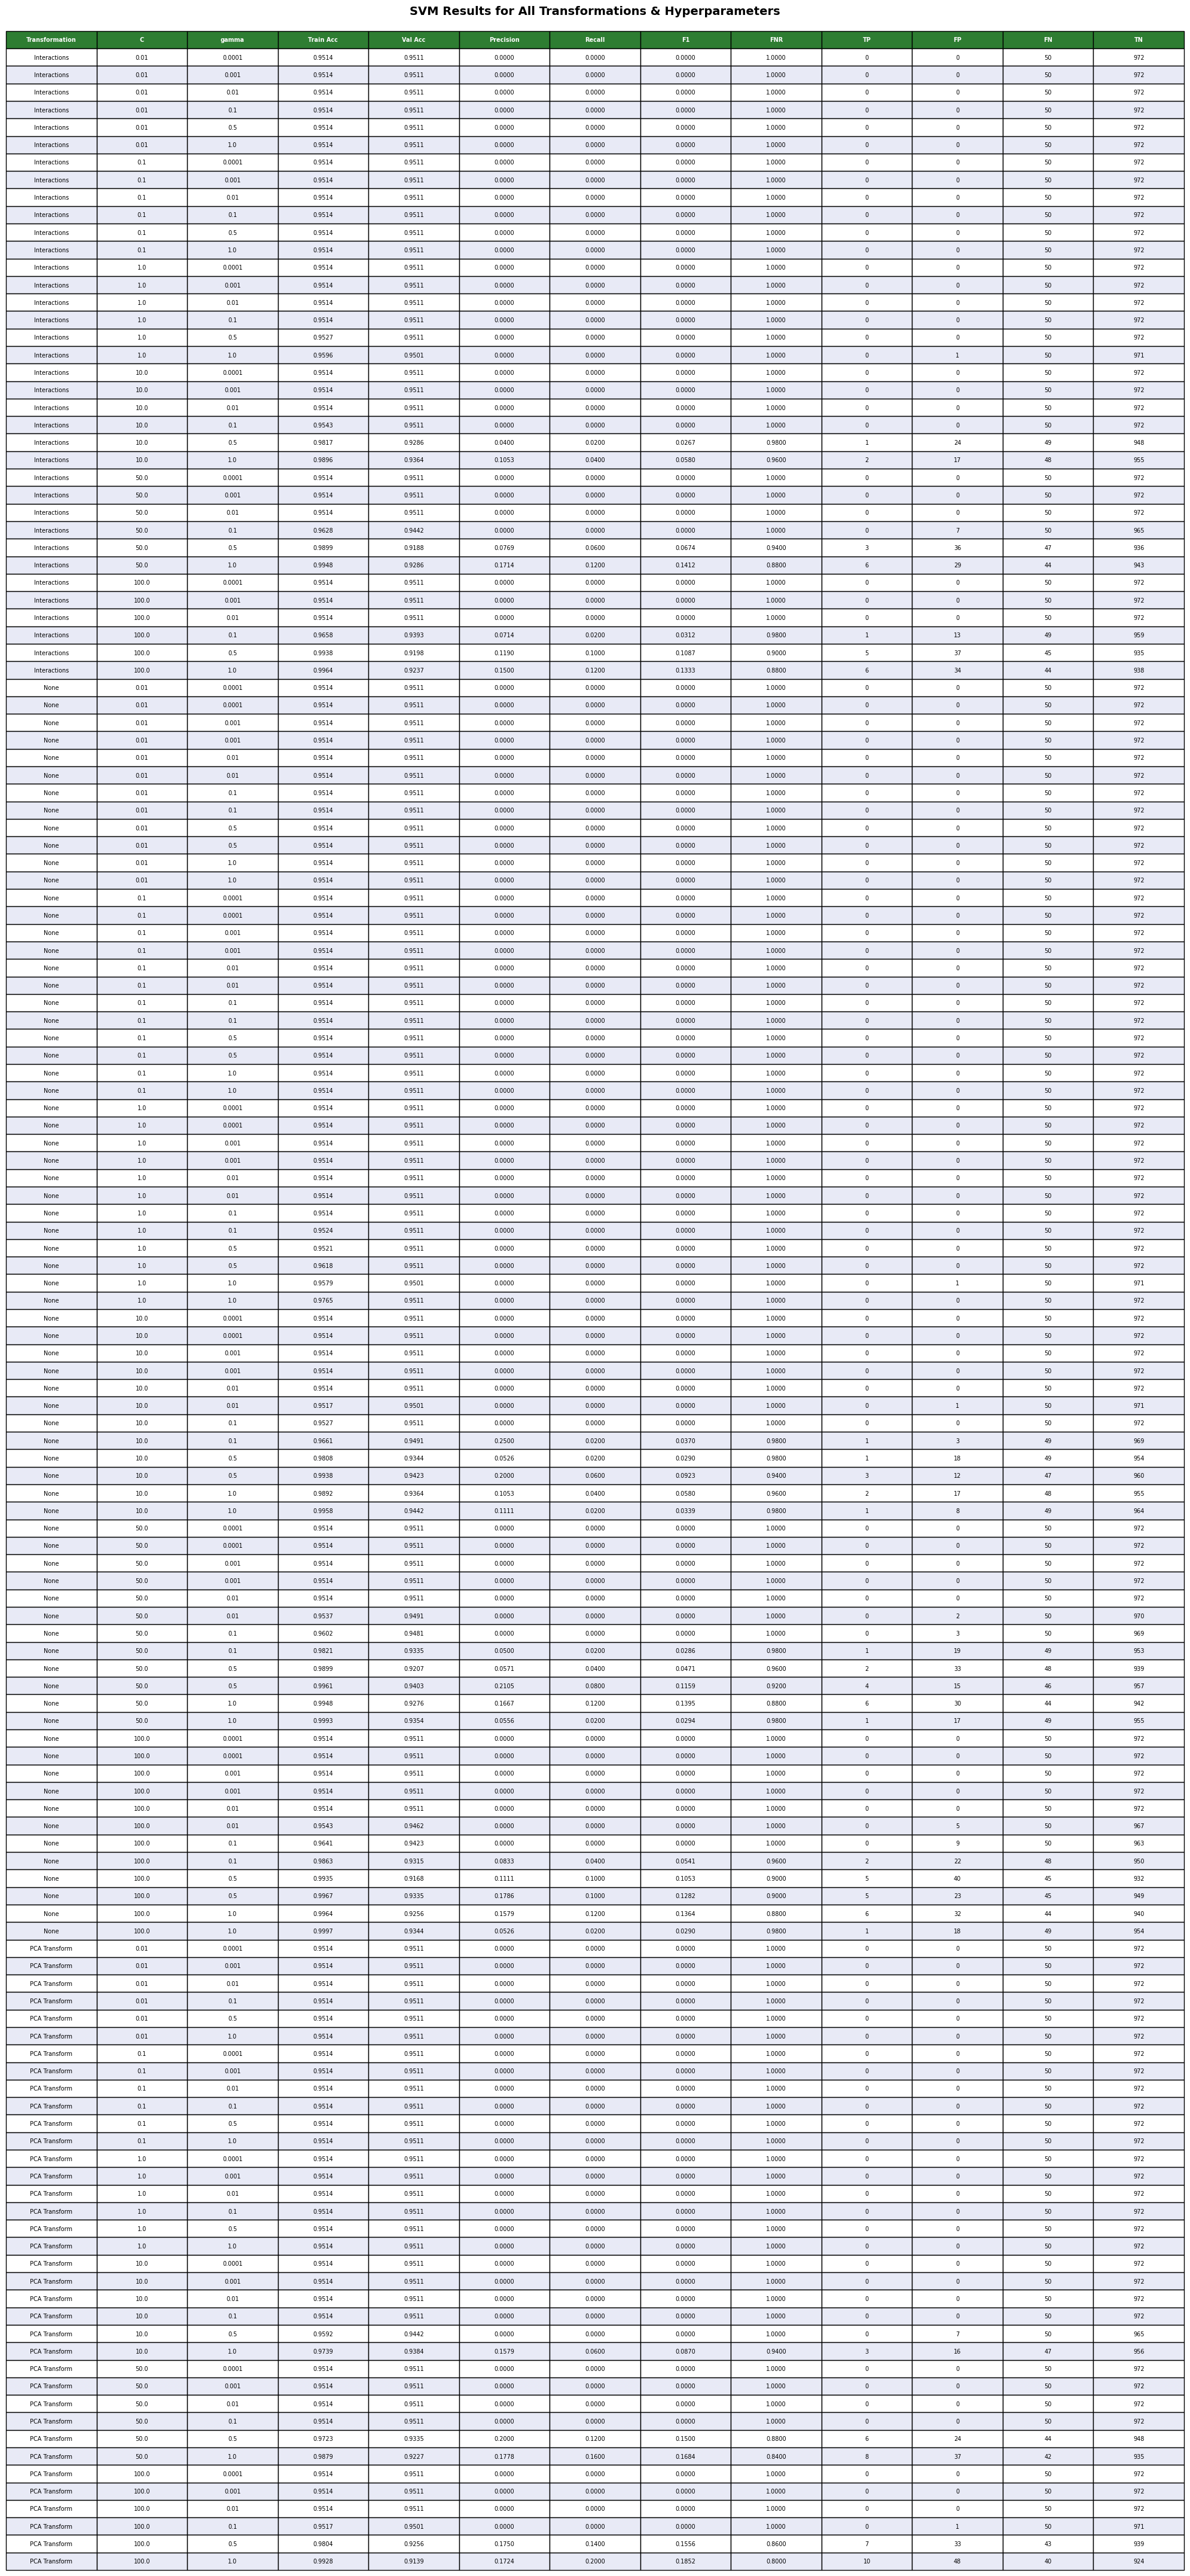


BEST SVM MODEL:
  Transformation: PCA Transform
  C: 100.0 | gamma: 1.0
  Train Acc: 0.9928
  Val Acc: 0.9139
  Precision: 0.1724
  Recall: 0.2000
  F1: 0.1852
  FNR: 0.8000
  TP=10, FP=48, FN=40, TN=924


In [ ]:
import matplotlib.pyplot as plt

print("=" * 150)
print("SVM Results")
print("=" * 150)

print(f"\n{'Transformation':<18} {'C':<8} {'gamma':<10} {'TrainAcc':<10} {'ValAcc':<10}"
      f"{'Precision':<10} {'Recall':<10} {'F1':<10} {'FNR':<10} {'TP':<5} {'FP':<5} {'FN':<5} {'TN':<5}")
print("-" * 150)

for _, row in svm_results_df.iterrows():
    print(f"{row['Transformation']:<18} {row['C']:<8} {row['gamma']:<10} "
          f"{row['Train Acc']:<10.4f} {row['Val Acc']:<10.4f} {row['Precision']:<10.4f} "
          f"{row['Recall']:<10.4f} {row['F1']:<10.4f} {row['FNR']:<10.4f} "
          f"{int(row['TP']):<5} {int(row['FP']):<5} {int(row['FN']):<5} {int(row['TN']):<5}")

print("=" * 150)


fig, ax = plt.subplots(figsize=(20, max(8, len(svm_results_df) * 0.3)))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in svm_results_df.iterrows():
    table_data.append([
        row['Transformation'],
        row['C'],
        row['gamma'],
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1']:.4f}",
        f"{row['FNR']:.4f}",
        int(row['TP']),
        int(row['FP']),
        int(row['FN']),
        int(row['TN'])
    ])

column_labels = ['Transformation', 'C', 'gamma', 'Train Acc', 'Val Acc',
                 'Precision', 'Recall', 'F1', 'FNR', 'TP', 'FP', 'FN', 'TN']

table = ax.table(cellText=table_data,
                colLabels=column_labels,
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

# Style table
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1, 1.5)

# Highlight header + alternating rows
for i in range(len(table_data) + 1):
    for j in range(len(column_labels)):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#2e7d32')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:
            cell.set_facecolor('#E8EAF6')
        else:
            cell.set_facecolor('white')

plt.title('SVM Results for All Transformations & Hyperparameters',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

best_svm = svm_results_df.loc[svm_results_df['F1'].idxmax()]
print(f"\n{'='*150}")
print("BEST SVM MODEL:")
print(f"  Transformation: {best_svm['Transformation']}")
print(f"  C: {best_svm['C']} | gamma: {best_svm['gamma']}")
print(f"  Train Acc: {best_svm['Train Acc']:.4f}")
print(f"  Val Acc: {best_svm['Val Acc']:.4f}")
print(f"  Precision: {best_svm['Precision']:.4f}")
print(f"  Recall: {best_svm['Recall']:.4f}")
print(f"  F1: {best_svm['F1']:.4f}")
print(f"  FNR: {best_svm['FNR']:.4f}")
print(f"  TP={int(best_svm['TP'])}, FP={int(best_svm['FP'])}, FN={int(best_svm['FN'])}, TN={int(best_svm['TN'])}")
print("=" * 150)


# Results

# Comparison Charts



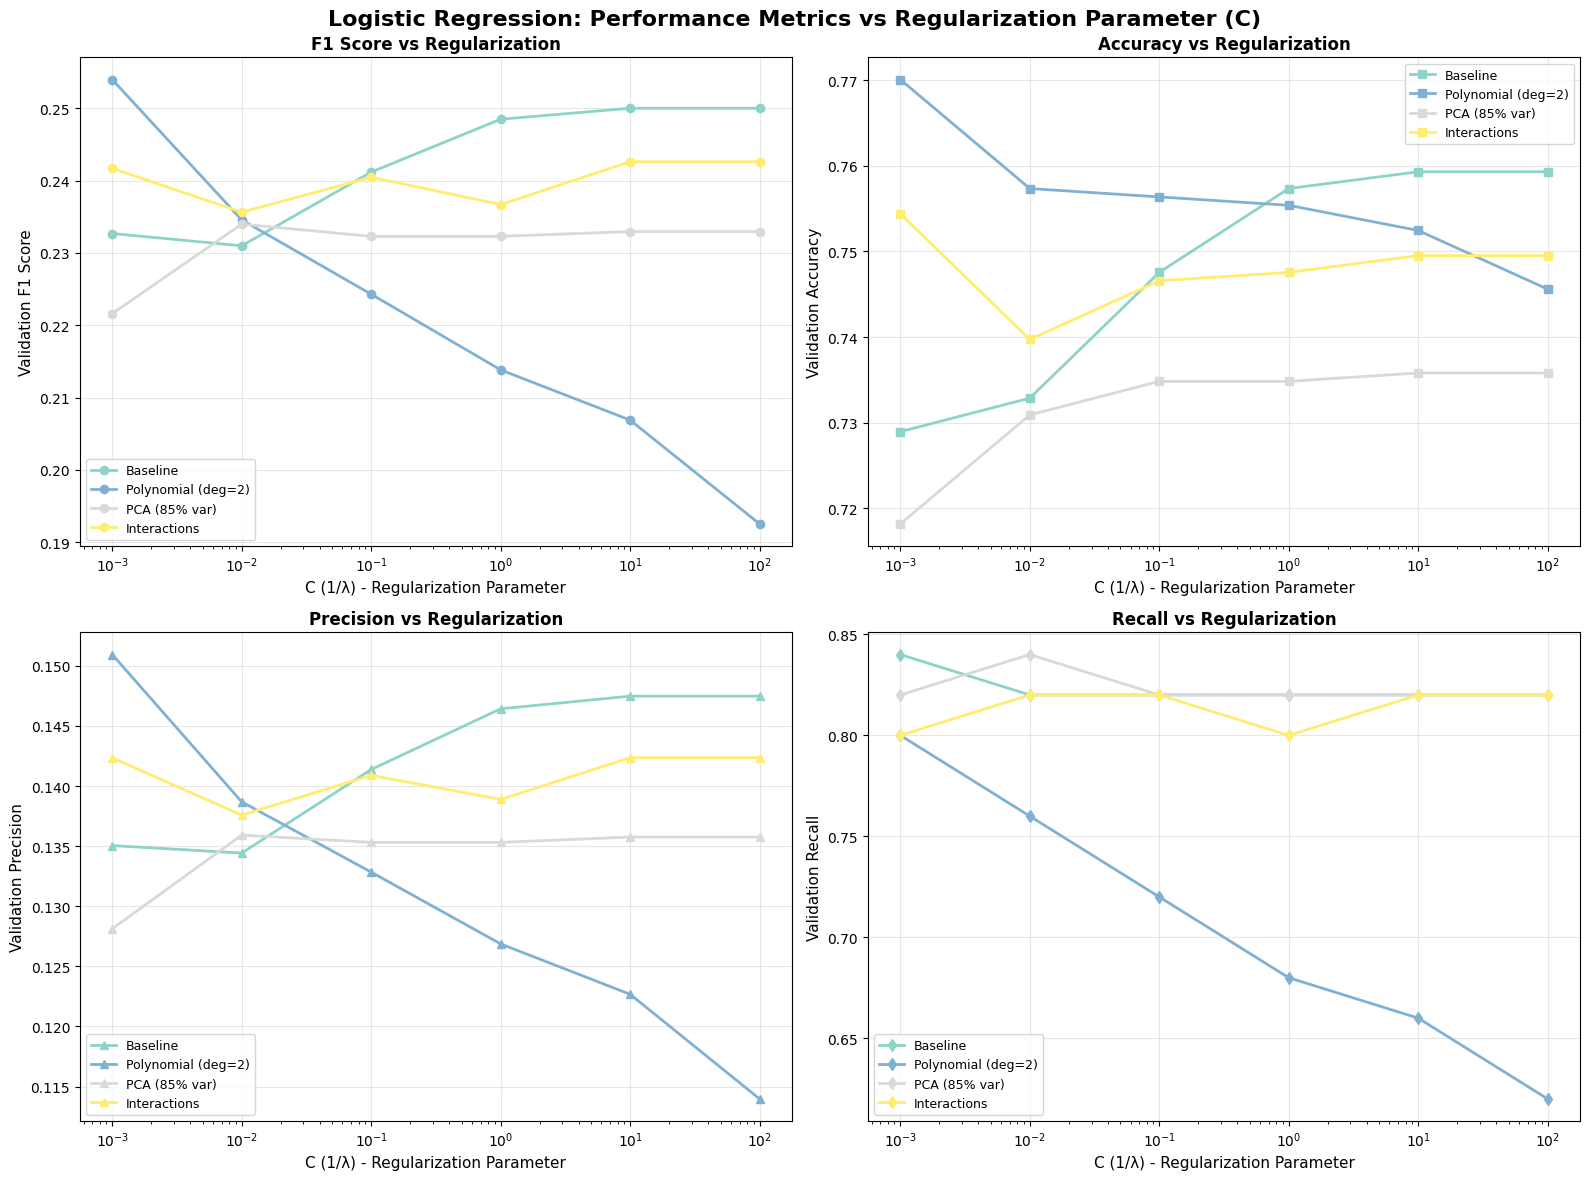

In [ ]:
# Plot 1: Logistic Regression - F1 Score vs Regularization (C)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Logistic Regression: Performance Metrics vs Regularization Parameter (C)', 
             fontsize=16, fontweight='bold')

transformations_lr = lr_results_df['transformation'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(transformations_lr)))
color_map = dict(zip(transformations_lr, colors))

# F1 Score
ax = axes[0, 0]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_f1'], marker='o', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation F1 Score', fontsize=11)
ax.set_title('F1 Score vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[0, 1]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_acc'], marker='s', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Accuracy vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 0]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_precision'], marker='^', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Precision', fontsize=11)
ax.set_title('Precision vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 1]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_recall'], marker='d', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Recall', fontsize=11)
ax.set_title('Recall vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5. Comparison Across Transformations - Bar Charts


### 6. Train vs Validation Performance - Overfitting Analysis
